![Nestle](graphics/01_Intro.png)

# 1. Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from math import sqrt

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# time
import datetime as dt
import time as time

# pipeline
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error

# model interpretability
import shap
shap.initjs()

# saving models
from joblib import dump

# own functions
from own_functions import plot_products
from own_functions import MakeTSTransformer
from own_functions import FeatureEngineeringTransformer
from own_functions import model_evaluation
from own_functions import plot_true_pred

![SellIn_SellOut](graphics/02_SellIn_SellOut.png)

# 2. Load dataset

In [2]:
dataset = pd.read_csv('History_SellIn_SellOut.csv', sep=';')
dataset['PERIOD_TAG'] = pd.to_datetime(dataset['PERIOD_TAG'], format='%Y-%m-%d')
dataset

PERIOD_TAG product_group customer_name  dispatches_SellIn  orders_SellIn  \
0    2016-08-07    Product_01   Customer_01                130            130   
1    2016-08-14    Product_01   Customer_01                  4              5   
2    2016-08-21    Product_01   Customer_01                130            130   
3    2016-08-28    Product_01   Customer_01                 61             61   
4    2016-09-04    Product_01   Customer_01                 57             58   
...         ...           ...           ...                ...            ...   
6799 2019-12-01    Product_29   Customer_01               2504           3720   
6800 2019-12-08    Product_29   Customer_01               3053           4918   
6801 2019-12-15    Product_29   Customer_01                650           1903   
6802 2019-12-22    Product_29   Customer_01               1863           2383   
6803 2019-12-29    Product_29   Customer_01                842           2075   

          Sellout  numeric_distribution_selling_promotion  type_promo_1  \
0        0.000000                                     0.0           0.0   
1      102.274039                                     0.1           0.0   
2       93.380644                                     0.0           0.0   
3      101.162365                                     0.0           0.0   
4      120.060829                                     0.1           0.0   
...           ...                                     ...           ...   
6799  1320.611349                                     1.0           0.0   
6800  1626.462092                                     0.8           0.0   
6801  1509.100761                                     0.5           0.0   
6802  2568.909150                                    66.1           0.0   
6803  1333.651497                                     0.4           0.0   

      type_promo_2  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
6799           0.0  
6800           0.0  
6801           0.0  
6802           0.0  
6803           0.0  

[6804 rows x 9 columns]

# 3. Exploratory Data Analysis

In [3]:
list(dataset['customer_name'].unique())

['Customer_01']

In [4]:
list(dataset['product_group'].sort_values().unique())

['Product_01',
 'Product_02',
 'Product_03',
 'Product_04',
 'Product_05',
 'Product_06',
 'Product_07',
 'Product_08',
 'Product_09',
 'Product_10',
 'Product_11',
 'Product_12',
 'Product_13',
 'Product_14',
 'Product_15',
 'Product_16',
 'Product_17',
 'Product_18',
 'Product_19',
 'Product_20',
 'Product_21',
 'Product_22',
 'Product_23',
 'Product_24',
 'Product_25',
 'Product_26',
 'Product_27',
 'Product_28',
 'Product_29',
 'Product_30',
 'Product_31',
 'Product_32',
 'Product_33',
 'Product_34',
 'Product_35',
 'Product_37',
 'Product_38',
 'Product_39',
 'Product_40',
 'Product_41',
 'Product_42']

In [5]:
biggest_products = dataset.copy()
biggest_products = biggest_products.loc[
    ((biggest_products['PERIOD_TAG']>='2019-01-01')&(biggest_products['PERIOD_TAG']<'2020-01-01')), :]
biggest_products = biggest_products.groupby(['customer_name', 'product_group'])[['dispatches_SellIn']].sum()
biggest_products.sort_values(by=['dispatches_SellIn'], ascending=False, inplace=True)
biggest_products.reset_index(inplace=True)
biggest_products

customer_name product_group  dispatches_SellIn
0    Customer_01    Product_34            1239947
1    Customer_01    Product_37             397179
2    Customer_01    Product_04             354670
3    Customer_01    Product_20             349369
4    Customer_01    Product_42             211624
5    Customer_01    Product_41             174605
6    Customer_01    Product_24             169556
7    Customer_01    Product_39             143229
8    Customer_01    Product_30             136329
9    Customer_01    Product_07             114656
10   Customer_01    Product_08             102139
11   Customer_01    Product_27              94262
12   Customer_01    Product_32              90339
13   Customer_01    Product_29              79817
14   Customer_01    Product_19              68611
15   Customer_01    Product_17              48711
16   Customer_01    Product_02              42854
17   Customer_01    Product_16              36867
18   Customer_01    Product_05              21847
19   Customer_01    Product_11              19999
20   Customer_01    Product_18              16492
21   Customer_01    Product_40              16255
22   Customer_01    Product_28              12501
23   Customer_01    Product_35              10657
24   Customer_01    Product_13               9493
25   Customer_01    Product_26               9261
26   Customer_01    Product_06               8226
27   Customer_01    Product_01               8033
28   Customer_01    Product_25               7559
29   Customer_01    Product_12               7512
30   Customer_01    Product_23               6076
31   Customer_01    Product_15               4652
32   Customer_01    Product_03               4512
33   Customer_01    Product_22               2332
34   Customer_01    Product_38               1855
35   Customer_01    Product_09               1633
36   Customer_01    Product_31                955
37   Customer_01    Product_14                783
38   Customer_01    Product_33                362
39   Customer_01    Product_21                 93
40   Customer_01    Product_10                 54

In [6]:
dataset.describe()

dispatches_SellIn  orders_SellIn        Sellout  \
count        6804.000000    6804.000000    6804.000000   
mean         1743.456055    1877.484421    1743.456055   
std          4746.466821    5140.428336    5265.857436   
min             0.000000       0.000000       0.000000   
25%            46.000000      55.000000      97.151468   
50%           321.500000     349.500000     352.139572   
75%          1686.500000    1748.500000    1873.847017   
max         72152.000000   82339.000000  137159.755326   

       numeric_distribution_selling_promotion  type_promo_1  type_promo_2  
count                             6804.000000   6804.000000   6804.000000  
mean                                 5.941549      0.054527      0.074515  
std                                 17.835099      0.227071      0.262626  
min                                  0.000000      0.000000      0.000000  
25%                                  0.000000      0.000000      0.000000  
50%                                  0.200000      0.000000      0.000000  
75%                                  1.400000      0.000000      0.000000  
max                                 97.500000      1.000000      1.000000

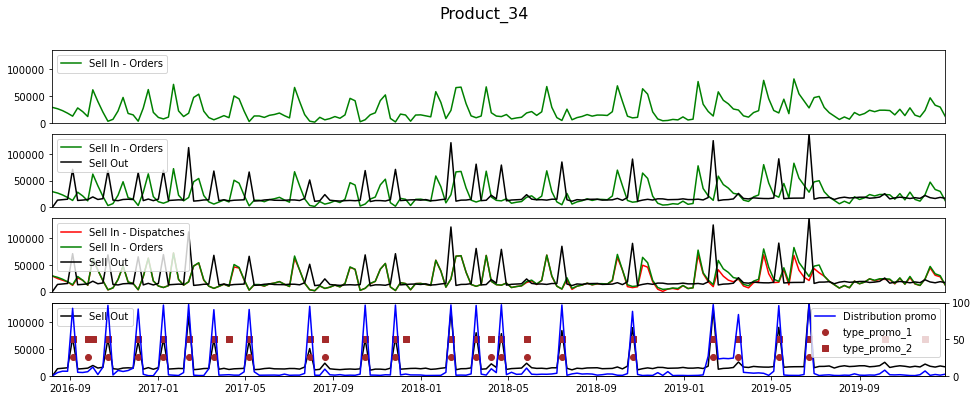

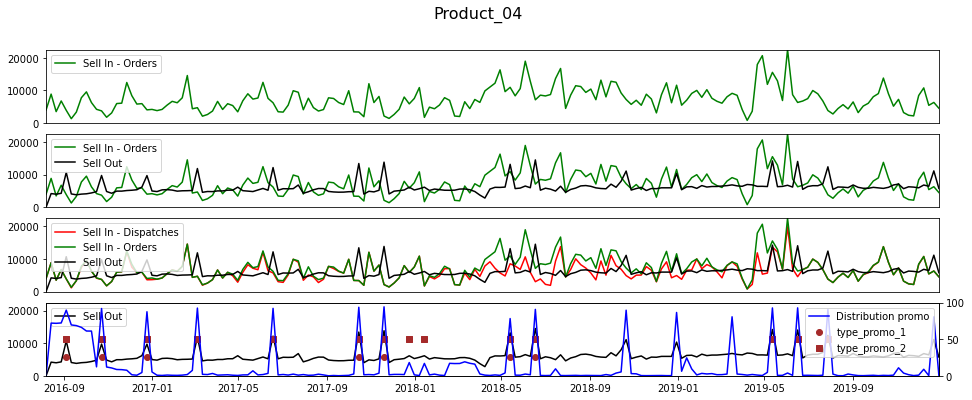

In [7]:
plot_products(df=dataset.copy(), num=2)

In [8]:
increase_sell_In_Out = pd.DataFrame()
for prod in dataset['product_group'].unique():
    one_prod = dataset.loc[dataset['product_group']==prod, :].copy()
    for shift in range(1, 7):
        one_prod[f'SellOut_Shift_{shift}'] = one_prod['Sellout'].shift(-shift)
    one_prod.dropna(inplace=True)

    increase_sell_In_Out = pd.concat([increase_sell_In_Out, one_prod])
increase_sell_In_Out

PERIOD_TAG product_group customer_name  dispatches_SellIn  orders_SellIn  \
0    2016-08-07    Product_01   Customer_01                130            130   
1    2016-08-14    Product_01   Customer_01                  4              5   
2    2016-08-21    Product_01   Customer_01                130            130   
3    2016-08-28    Product_01   Customer_01                 61             61   
4    2016-09-04    Product_01   Customer_01                 57             58   
...         ...           ...           ...                ...            ...   
6793 2019-10-20    Product_29   Customer_01                783           1391   
6794 2019-10-27    Product_29   Customer_01               1828           2289   
6795 2019-11-03    Product_29   Customer_01               1218           2338   
6796 2019-11-10    Product_29   Customer_01                948           2814   
6797 2019-11-17    Product_29   Customer_01               1744           2248   

          Sellout  numeric_distribution_selling_promotion  type_promo_1  \
0        0.000000                                     0.0           0.0   
1      102.274039                                     0.1           0.0   
2       93.380644                                     0.0           0.0   
3      101.162365                                     0.0           0.0   
4      120.060829                                     0.1           0.0   
...           ...                                     ...           ...   
6793  1573.116032                                     0.6           0.0   
6794  1736.710616                                     0.8           0.0   
6795  1595.639924                                     2.9           0.0   
6796  1345.506177                                     2.7           0.0   
6797  1437.972681                                     0.6           0.0   

      type_promo_2  SellOut_Shift_1  SellOut_Shift_2  SellOut_Shift_3  \
0              0.0       102.274039        93.380644       101.162365   
1              0.0        93.380644       101.162365       120.060829   
2              0.0       101.162365       120.060829       202.324730   
3              0.0       120.060829       202.324730       110.055760   
4              0.0       202.324730       110.055760       106.720737   
...            ...              ...              ...              ...   
6793           0.0      1736.710616      1595.639924      1345.506177   
6794           0.0      1595.639924      1345.506177      1437.972681   
6795           0.0      1345.506177      1437.972681      1377.513813   
6796           0.0      1437.972681      1377.513813      1320.611349   
6797           0.0      1377.513813      1320.611349      1626.462092   

      SellOut_Shift_4  SellOut_Shift_5  SellOut_Shift_6  
0          120.060829       202.324730       110.055760  
1          202.324730       110.055760       106.720737  
2          110.055760       106.720737       122.284177  
3          106.720737       122.284177       108.944085  
4          122.284177       108.944085       106.720737  
...               ...              ...              ...  
6793      1437.972681      1377.513813      1320.611349  
6794      1377.513813      1320.611349      1626.462092  
6795      1320.611349      1626.462092      1509.100761  
6796      1626.462092      1509.100761      2568.909150  
6797      1509.100761      2568.909150      1333.651497  

[6558 rows x 15 columns]

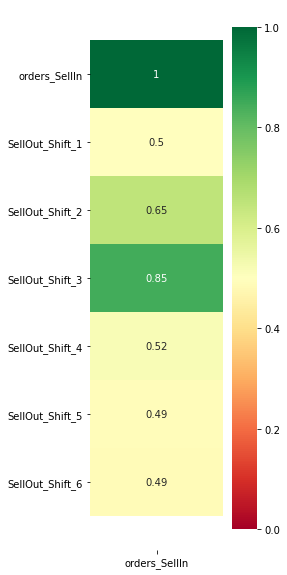

In [9]:
plt.figure(figsize = (3, 10))
columns_to_corr = ['orders_SellIn']+list(increase_sell_In_Out.loc[:, 'SellOut_Shift_1':].columns)
ax = sns.heatmap(pd.DataFrame(increase_sell_In_Out[columns_to_corr].corr()['orders_SellIn']),
                 annot = True, cmap='RdYlGn', vmin=0, vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.show()

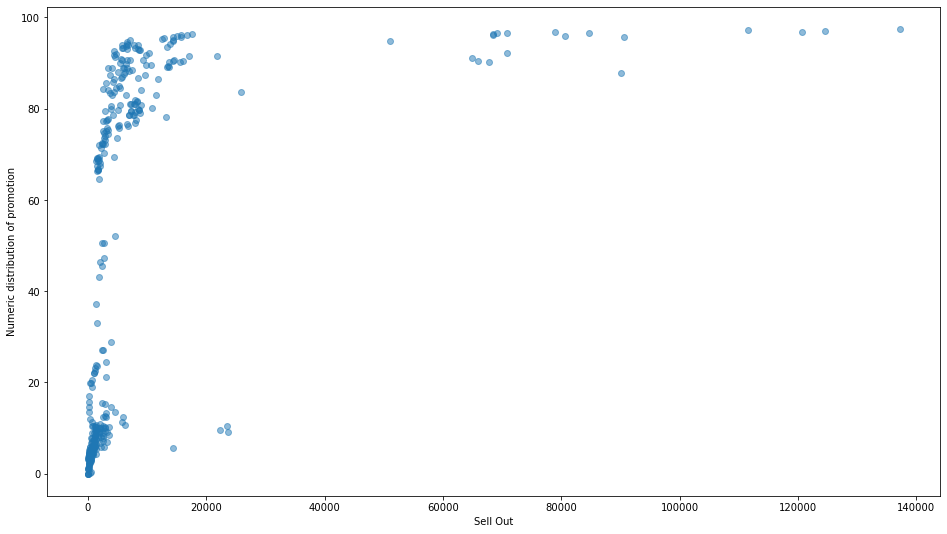

In [10]:
plt.figure(figsize=(16, 9))
plt.scatter(increase_sell_In_Out.loc[increase_sell_In_Out['type_promo_1']==1, 'Sellout'], 
            increase_sell_In_Out.loc[increase_sell_In_Out['type_promo_1']==1,
                                     'numeric_distribution_selling_promotion'],
            alpha=0.5)
plt.xlabel('Sell Out')
plt.ylabel('Numeric distribution of promotion')
plt.show()

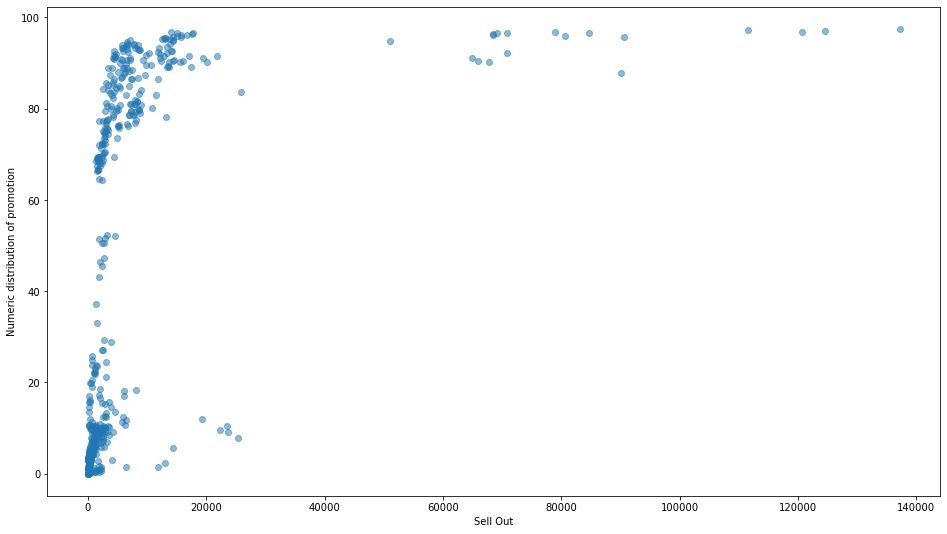

In [11]:
plt.figure(figsize=(16, 9))
plt.scatter(increase_sell_In_Out.loc[increase_sell_In_Out['type_promo_2']==1, 'Sellout'], 
            increase_sell_In_Out.loc[increase_sell_In_Out['type_promo_2']==1,
                                     'numeric_distribution_selling_promotion'],
            alpha=0.5)
plt.xlabel('Sell Out')
plt.ylabel('Numeric distribution of promotion')
plt.show()

# 4. Data Preprocessing - Feature Engineering

In [12]:
dataset

PERIOD_TAG product_group customer_name  dispatches_SellIn  orders_SellIn  \
0    2016-08-07    Product_01   Customer_01                130            130   
1    2016-08-14    Product_01   Customer_01                  4              5   
2    2016-08-21    Product_01   Customer_01                130            130   
3    2016-08-28    Product_01   Customer_01                 61             61   
4    2016-09-04    Product_01   Customer_01                 57             58   
...         ...           ...           ...                ...            ...   
6799 2019-12-01    Product_29   Customer_01               2504           3720   
6800 2019-12-08    Product_29   Customer_01               3053           4918   
6801 2019-12-15    Product_29   Customer_01                650           1903   
6802 2019-12-22    Product_29   Customer_01               1863           2383   
6803 2019-12-29    Product_29   Customer_01                842           2075   

          Sellout  numeric_distribution_selling_promotion  type_promo_1  \
0        0.000000                                     0.0           0.0   
1      102.274039                                     0.1           0.0   
2       93.380644                                     0.0           0.0   
3      101.162365                                     0.0           0.0   
4      120.060829                                     0.1           0.0   
...           ...                                     ...           ...   
6799  1320.611349                                     1.0           0.0   
6800  1626.462092                                     0.8           0.0   
6801  1509.100761                                     0.5           0.0   
6802  2568.909150                                    66.1           0.0   
6803  1333.651497                                     0.4           0.0   

      type_promo_2  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
6799           0.0  
6800           0.0  
6801           0.0  
6802           0.0  
6803           0.0  

[6804 rows x 9 columns]

## *Applied machine learning is basically feature engineering* ~ **Andrew Ng**

It is very often said that data is the **fuel** for machine learning. However, in reality this is not quite true. If we simply take the data we have as input, we would not prepare good models in most cases. It is better to say that data is like **oil**. So, first of all, a proper process of converting crude **oil** into **fuel** has to be done. This process is referred to as feature engineering.

It is the process of creating new features to enable machine learning algorithms. Correctly preparing the characteristics greatly increases their quality as we transform the raw data into information that the model will convert into knowledge.

So how can we enrich our data:
#### 1) The values which we will forecast - how much we will sell in a week, in 2 weeks, etc ➞ it is our *y*

| PERIOD_TAG          | product_group   |   orders_SellIn |   SellOut |   orders_SellIn_1W |   SellOut_1W |   orders_SellIn_2W |   SellOut_2W |
|:--------------------|:----------------|----------------:|----------:|-------------------:|-------------:|-------------------:|-------------:|
| 2019-12-01 | Product_34      |           23538 |     19794 |              47019 |        16137 |              33194 |        14747 |
| 2019-12-08 | Product_34      |           47019 |     16137 |              33194 |        14747 |              29624 |        16637 |
| 2019-12-15 | Product_34      |           33194 |     14747 |              29624 |        16637 |              12224 |        15111 |
| 2019-12-22 | Product_34      |           29624 |     16637 |              12224 |        15111 |                nan |          nan |
| 2019-12-29 | Product_34      |           12224 |     15111 |                nan |          nan |                nan |          nan |

#### 2) Values from the future that we know - what the promotion will be a week from now, 2 weeks from now, etc ➞ it is our *X*

| PERIOD_TAG          | product_group   |   SellOut |   distribution |   promo_1 |   distribution_1W |   promo_1_1W |   distribution_2W |   promo_1_2W |
|:--------------------|:----------------|----------:|---------------:|----------:|------------------:|-------------:|------------------:|-------------:|
| 2016-08-07 | Product_34      |         0 |         0      |         0 |            0      |            0 |            0      |            0 |
| 2016-08-14 | Product_34      |     11949 |         0      |         0 |            0      |            0 |            0      |            0 |
| 2016-08-21 | Product_34      |     12778 |         0      |         0 |            0      |            0 |           86.1272 |            1 |
| 2016-08-28 | Product_34      |     13554 |         0      |         0 |           86.1272 |            1 |            0      |            0 |
| 2016-09-04 | Product_34      |     63963 |        86.1272 |         1 |            0      |            0 |            0      |            0 |

#### 3) Lagged values - how much we sold a week ago, 2 weeks ago, etc ➞ it is our *X*

| PERIOD_TAG          | product_group   |   orders_SellIn |   SellOut |   orders_SellIn_lag1 |   SellOut_lag1 |   orders_SellIn_lag2 |   SellOut_lag2 |
|:--------------------|:----------------|----------------:|----------:|---------------------:|---------------:|---------------------:|---------------:|
| 2016-08-07 | Product_34      |           29055 |         0 |                  nan |            nan |                  nan |            nan |
| 2016-08-14 | Product_34      |           26605 |     11949 |                29055 |              0 |                  nan |            nan |
| 2016-08-21 | Product_34      |           22996 |     12778 |                26605 |          11949 |                29055 |              0 |
| 2016-08-28 | Product_34      |           18239 |     13554 |                22996 |          12778 |                26605 |          11949 |
| 2016-09-04 | Product_34      |           12672 |     63963 |                18239 |          13554 |                22996 |          12778 |

#### 4) The rolling statistics ➞ it is our *X*
This can be the mean, median, standard deviation, sum, difference between different values (e.g. *orders* and *dispatches*)

| PERIOD_TAG          | product_group   |   orders_SellIn |   SellOut |   orders_SellIn_mean2 |   SellOut_mean2 |   orders_SellIn_mean3 |   SellOut_mean3 |
|:--------------------|:----------------|----------------:|----------:|----------------------:|----------------:|----------------------:|----------------:|
| 2016-08-07 | Product_34      |           29055 |         0 |                 nan   |           nan   |                 nan   |          nan    |
| 2016-08-14 | Product_34      |           26605 |     11949 |               27830   |          5974.5 |                 nan   |          nan    |
| 2016-08-21 | Product_34      |           22996 |     12778 |               24800.5 |         12363.5 |               26218.7 |         8242.33 |
| 2016-08-28 | Product_34      |           18239 |     13554 |               20617.5 |         13166   |               22613.3 |        12760.3  |
| 2016-09-04 | Product_34      |           12672 |     63963 |               15455.5 |         38758.5 |               17969   |        30098.3  |

#### 5) Date-related variables (seasonality)➞ it is our *X*

<div>
<img src="graphics/03_Cyclic.png" width="600"/>
</div>

| PERIOD_TAG          |   week_sin |   week_cos |
|:--------------------|-----------:|-----------:|
| 2016-08-07 |      -0.57 |      -0.82 |
| 2016-08-14 |      -0.66 |      -0.75 |
| 2018-12-23 |      -0.12 |       0.99 |
| 2018-12-30 |       0    |       1    |

In [13]:
scenario = 1
promo_variables = ['numeric_distribution_selling_promotion', 'type_promo_1', 'type_promo_2']
promo_sellin = []
cl4_col_name = 'customer_name'
mg1_col_name = 'product_group'
sellout_w = 18
sellin_w = 13

steps_preprocessing = [
    ('make_ts', MakeTSTransformer(date_column='PERIOD_TAG')),
    ('feature_engineering_transformer', FeatureEngineeringTransformer(scenario=scenario,
                                                                      promo_variables=promo_variables,
                                                                      promo_sellin=promo_sellin, 
                                                                      cl4_col_name=cl4_col_name, 
                                                                      mg1_col_name=mg1_col_name,
                                                                      sellout_w=sellout_w, 
                                                                      sellin_w=sellin_w, 
                                                                      nr_horizon=1, 
                                                                      type_forecast='Sellout',
                                                                      target='Sellout'))
]

pipeline_preprocessing = Pipeline(steps = steps_preprocessing)
pipeline_preprocessing.fit_transform(dataset)

Categoric features:
1
Selected_variables:
['Sellout_1W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_1W', 'type_promo_1_1W', 'type_promo_2_1W', 'Sellout', 'Sellout_lag_1', 'Sellout_lag_2', 'Sellout_lag_3', 'Sellout_lag_4', 'Sellout_lag_5', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_2', 'Sellout_window_std_3', 'Sellout_window_std_4', 'Sellout_window_std_5', 'Sellout_window_min_2', 'Sellout_window_min_3', 'Sellout_window_min_4', 'Sellout_window_min_5', 'Sellout_window_max_2', 'Sellout_window_max_3', 'Sellout_window_max_4', 'Sellout_window_max_5']
Number: 29


Sellout_1W customer_name product_group  week_sin  week_cos  \
PERIOD_TAG                                                                
2016-10-09   106.720737   Customer_01    Product_01 -0.999561  0.029633   
2016-10-16   105.609062   Customer_01    Product_01 -0.989040  0.147647   
2016-10-23   118.949154   Customer_01    Product_01 -0.964636  0.263587   
2016-10-30    86.710598   Customer_01    Product_01 -0.926690  0.375828   
2016-11-06    96.715668   Customer_01    Product_01 -0.875735  0.482792   
...                 ...           ...           ...       ...       ...   
2019-11-24  1320.611349   Customer_01    Product_29 -0.652822  0.757511   
2019-12-01  1626.462092   Customer_01    Product_29 -0.558647  0.829406   
2019-12-08  1509.100761   Customer_01    Product_29 -0.456629  0.889657   
2019-12-15  2568.909150   Customer_01    Product_29 -0.348202  0.937420   
2019-12-22  1333.651497   Customer_01    Product_29 -0.234886  0.972023   

            customer_name_Customer_01  \
PERIOD_TAG                              
2016-10-09                          1   
2016-10-16                          1   
2016-10-23                          1   
2016-10-30                          1   
2016-11-06                          1   
...                               ...   
2019-11-24                          1   
2019-12-01                          1   
2019-12-08                          1   
2019-12-15                          1   
2019-12-22                          1   

            numeric_distribution_selling_promotion_1W  type_promo_1_1W  \
PERIOD_TAG                                                               
2016-10-09                                        0.0              0.0   
2016-10-16                                        0.0              0.0   
2016-10-23                                        0.0              0.0   
2016-10-30                                        0.0              0.0   
2016-11-06                                        0.0              0.0   
...                                               ...              ...   
2019-11-24                                        1.0              0.0   
2019-12-01                                        0.8              0.0   
2019-12-08                                        0.5              0.0   
2019-12-15                                       66.1              0.0   
2019-12-22                                        0.4              0.0   

            type_promo_2_1W      Sellout  ...  Sellout_window_std_4  \
PERIOD_TAG                                ...                         
2016-10-09              0.0   108.944085  ...              6.994131   
2016-10-16              0.0   106.720737  ...              7.484907   
2016-10-23              0.0   105.609062  ...              7.721937   
2016-10-30              0.0   118.949154  ...              6.088891   
2016-11-06              0.0    86.710598  ...             13.309176   
...                     ...          ...  ...                   ...   
2019-11-24              0.0  1377.513813  ...            111.143552   
2019-12-01              0.0  1320.611349  ...             50.712542   
2019-12-08              0.0  1626.462092  ...            132.826650   
2019-12-15              0.0  1509.100761  ...            137.044664   
2019-12-22              0.0  2568.909150  ...            556.214459   

            Sellout_window_std_5  Sellout_window_min_2  Sellout_window_min_3  \
PERIOD_TAG                                                                     
2016-10-09             40.845523            108.944085            106.720737   
2016-10-16              6.501157            106.720737            106.720737   
2016-10-23              6.942404            105.609062            105.609062   
2016-10-30              7.596893            105.609062            105.609062   
2016-11-06             11.696378             86.710598             86.710598   
...                          ...                   ...  

# 5. Modelling

## 5.1 Train Test Split

In [14]:
target_columns = [f'Sellout_{horizon}W' for horizon in range(1, sellout_w+1)]+\
                    [f'orders_SellIn_{horizon}W' for horizon in range(1, sellin_w+1)]
target_columns

['Sellout_1W',
 'Sellout_2W',
 'Sellout_3W',
 'Sellout_4W',
 'Sellout_5W',
 'Sellout_6W',
 'Sellout_7W',
 'Sellout_8W',
 'Sellout_9W',
 'Sellout_10W',
 'Sellout_11W',
 'Sellout_12W',
 'Sellout_13W',
 'Sellout_14W',
 'Sellout_15W',
 'Sellout_16W',
 'Sellout_17W',
 'Sellout_18W',
 'orders_SellIn_1W',
 'orders_SellIn_2W',
 'orders_SellIn_3W',
 'orders_SellIn_4W',
 'orders_SellIn_5W',
 'orders_SellIn_6W',
 'orders_SellIn_7W',
 'orders_SellIn_8W',
 'orders_SellIn_9W',
 'orders_SellIn_10W',
 'orders_SellIn_11W',
 'orders_SellIn_12W',
 'orders_SellIn_13W']

In [15]:
first_test_date = dt.datetime.strptime('2019-01-06', '%Y-%m-%d')
end_test_date = dt.datetime.strptime('2019-12-22', '%Y-%m-%d')

In [16]:
dataset

PERIOD_TAG product_group customer_name  dispatches_SellIn  orders_SellIn  \
0    2016-08-07    Product_01   Customer_01                130            130   
1    2016-08-14    Product_01   Customer_01                  4              5   
2    2016-08-21    Product_01   Customer_01                130            130   
3    2016-08-28    Product_01   Customer_01                 61             61   
4    2016-09-04    Product_01   Customer_01                 57             58   
...         ...           ...           ...                ...            ...   
6799 2019-12-01    Product_29   Customer_01               2504           3720   
6800 2019-12-08    Product_29   Customer_01               3053           4918   
6801 2019-12-15    Product_29   Customer_01                650           1903   
6802 2019-12-22    Product_29   Customer_01               1863           2383   
6803 2019-12-29    Product_29   Customer_01                842           2075   

          Sellout  numeric_distribution_selling_promotion  type_promo_1  \
0        0.000000                                     0.0           0.0   
1      102.274039                                     0.1           0.0   
2       93.380644                                     0.0           0.0   
3      101.162365                                     0.0           0.0   
4      120.060829                                     0.1           0.0   
...           ...                                     ...           ...   
6799  1320.611349                                     1.0           0.0   
6800  1626.462092                                     0.8           0.0   
6801  1509.100761                                     0.5           0.0   
6802  2568.909150                                    66.1           0.0   
6803  1333.651497                                     0.4           0.0   

      type_promo_2  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
6799           0.0  
6800           0.0  
6801           0.0  
6802           0.0  
6803           0.0  

[6804 rows x 9 columns]

## 5.2 Training models on different horizons

|---------------------------	Sellout_1W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_1W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_1W', 'type_promo_1_1W', 'type_promo_2_1W', 'Sellout', 'Sellout_lag_1', 'Sellout_lag_2', 'Sellout_lag_3', 'Sellout_lag_4', 'Sellout_lag_5', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_2', 'Sellout_window_std_3', 'Sellout_window_std_4', 'Sellout_window_std_5', 'Sellout_window_min_2', 'Sellout_window_min_3', 'Sellout_window_min_4', 'Sellout_window_min_5', 'Sellout_window_max_2', 'Sellout_window_max_3', 'Sellout_window_max_4', 'Sellout_window_max_5']
Number: 29


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   

            numeric_distribution_selling_promotion_1W  type_promo_1_1W  \
PERIOD_TAG                                                               
2016-10-09                                        0.0              0.0   
2016-10-16                                        0.0              0.0   
2016-10-23                                        0.0              0.0   
2016-10-30                                        0.0              0.0   
2016-11-06                                        0.0              0.0   
...                                               ...              ...   
2018-11-25                                        0.6              0.0   
2018-12-02                                        0.5              0.0   
2018-12-09                                        0.6              0.0   
2018-12-16                                        0.5              0.0   
2018-12-23                                       78.1              0.0   

            type_promo_2_1W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2016-10-09              0.0   108.944085     122.284177     106.720737   
2016-10-16              0.0   106.720737     108.944085     122.284177   
2016-10-23              0.0   105.609062     106.720737     108.944085   
2016-10-30              0.0   118.949154     105.609062     106.720737   
2016-11-06              0.0    86.710598     118.949154     105.609062   
...                     ...          ...            ...            ...   
2018-11-25              0.0  2241.719983    2444.435011    2276.098555   
2018-12-02              0.0  1974.989684    2241.719983    2444.435011   
2018-12-09              0.0  1816.136972    1974.989684    2241.719983   
2018-12-16              0.0  1632.389432    1816.136972    1974.989684   
2018-12-23              0.0  1653.727856    1632.389432    1816.136972   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2016-10-09     110.055760  ...              6.994131             40.845523   
2016-10-16     106.720737  ...              7.484907              6.501157   
2016-10-23     122.284177  ...              7.721937              6.942404   
2016-10-30     108.944085  ...              6.088891              7.596893   
2016-11-06     106.720737  ...             13.309176             11.696378   
...                   ...  ...                   ...                   ...   
2018-11-25    2683.899546  ...            202.027248            175.452067   
2018-12-02    2276.098555  ...            194.251330            262.156806   
2018-12-09    2444.435011  ...            278.946061            251.543348   
2018-12-16    2241.719983  ...            258.186294            325.236121   
2018-12-23    1974.989684  ...            159.795047            252.556716   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2016-10-09            108.944085            106.720737            106.720737   
2016-10-16            106.720737     

PERIOD_TAG
2016-10-09     106.720737
2016-10-16     105.609062
2016-10-23     118.949154
2016-10-30      86.710598
2016-11-06      96.715668
                 ...     
2018-11-25    1974.989684
2018-12-02    1816.136972
2018-12-09    1632.389432
2018-12-16    1653.727856
2018-12-23    3072.733049
Name: Sellout_1W, Length: 4262, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
2019-01-20  0.348202  0.937420                          1   
2019-01-27  0.456629  0.889657                          1   
...              ...       ...                        ...   
2019-11-17 -0.737833  0.674983                          1   
2019-11-24 -0.652822  0.757511                          1   
2019-12-01 -0.558647  0.829406                          1   
2019-12-08 -0.456629  0.889657                          1   
2019-12-15 -0.348202  0.937420                          1   

            numeric_distribution_selling_promotion_1W  type_promo_1_1W  \
PERIOD_TAG                                                               
2018-12-30                                        0.0              0.0   
2019-01-06                                        0.0              0.0   
2019-01-13                                        0.0              0.0   
2019-01-20                                        0.0              0.0   
2019-01-27                                        0.0              0.0   
...                                               ...              ...   
2019-11-17                                        0.5              0.0   
2019-11-24                                        1.0              0.0   
2019-12-01                                        0.8              0.0   
2019-12-08                                        0.5              0.0   
2019-12-15                                       66.1              0.0   

            type_promo_2_1W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2018-12-30              0.0   155.634407     121.172503     212.329799   
2019-01-06              0.0   126.730875     155.634407     121.172503   
2019-01-13              0.0   123.395852     126.730875     155.634407   
2019-01-20              0.0   131.177572     123.395852     126.730875   
2019-01-27              0.0   125.619200     131.177572     123.395852   
...                     ...          ...            ...            ...   
2019-11-17              0.0  1437.972681    1345.506177    1595.639924   
2019-11-24              0.0  1377.513813    1437.972681    1345.506177   
2019-12-01              0.0  1320.611349    1377.513813    1437.972681   
2019-12-08              0.0  1626.462092    1320.611349    1377.513813   
2019-12-15              0.0  1509.100761    1626.462092    1320.611349   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2018-12-30     131.177572  ...             40.820302             36.181542   
2019-01-06     212.329799  ...             41.738400             37.555841   
2019-01-13     121.172503  ...             16.096901             38.645676   
2019-01-20     155.634407  ...             14.618271             13.942541   
2019-01-27     126.730875  ...              3.272681             13.233128   
...                   ...  ...                   ...                   ...   
2019-11-17    1736.710616  ...            172.762388            150.914313   
2019-11-24    1595.639924  ...            111.143552            164.232034   
2019-12-01    1345.506177  ...             50.712542            109.887832   
2019-12-08    1437.972681  ...            132.826650            122.646963   
2019-12-15    1377.513813  ...            137.044664            119.035981   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2018-12-30            121.172503            121.172503            121.172503   
2019-01-06            126.730875     

PERIOD_TAG
2018-12-30     126.730875
2019-01-06     123.395852
2019-01-13     131.177572
2019-01-20     125.619200
2019-01-27     141.182641
                 ...     
2019-11-17    1377.513813
2019-11-24    1320.611349
2019-12-01    1626.462092
2019-12-08    1509.100761
2019-12-15    2568.909150
Name: Sellout_1W, Length: 2091, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-19972974.258221194

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


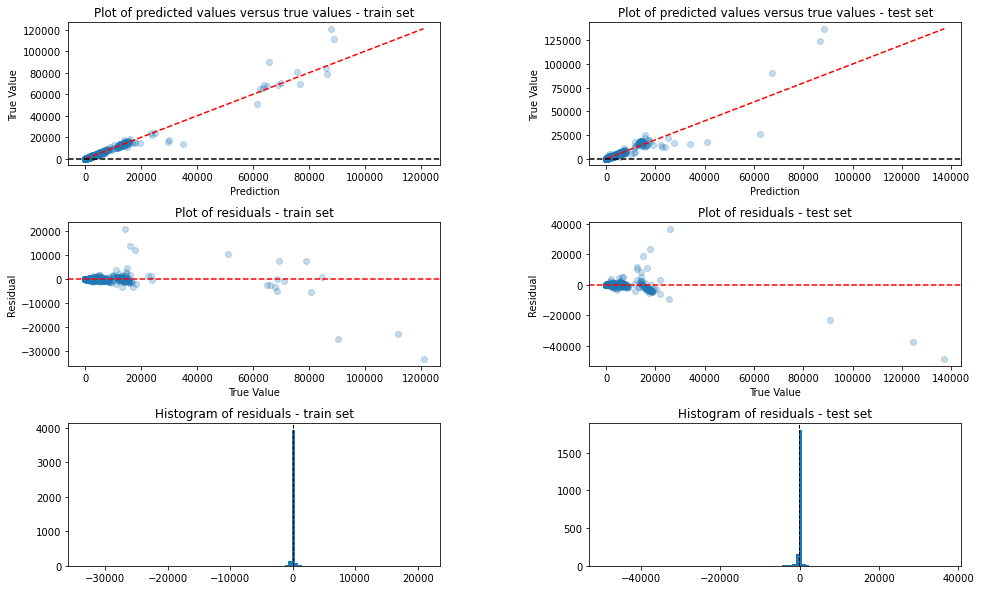

RMSE train: 906.4364714993966
DPA  train: 93.44620344514846
BIAS train: 0.10725209471894002

RMSE test:  1946.1828693073646
DPA  test: 83.29283843947381
BIAS test: -2.5236898416298574


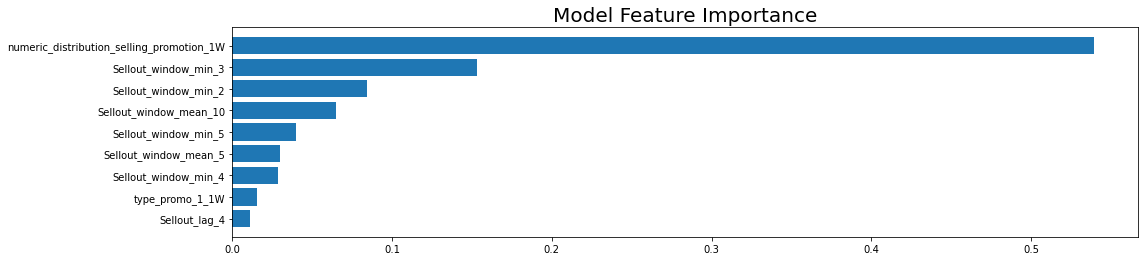

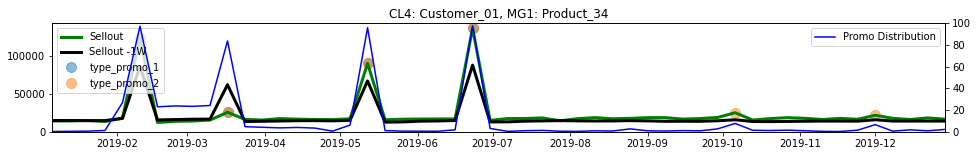

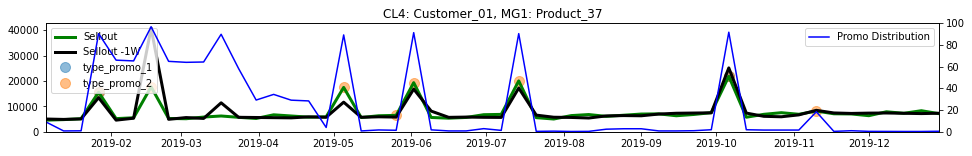

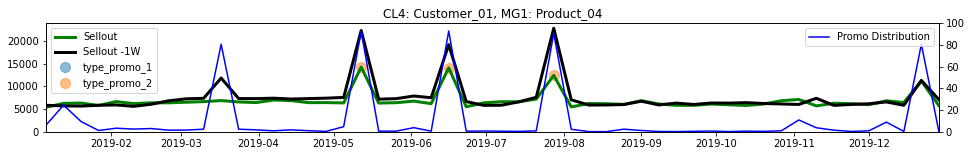

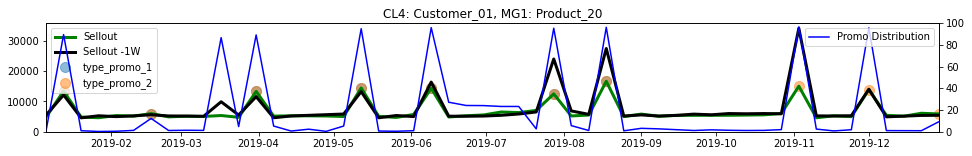

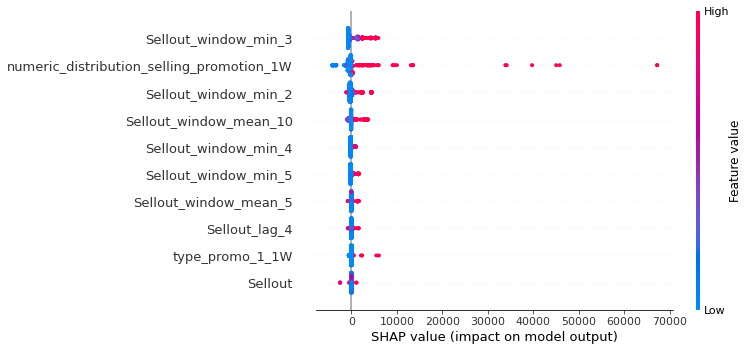

None

Finished iterating in: 22 seconds


|---------------------------	Sellout_2W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_2W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_2W', 'type_promo_1_2W', 'type_promo_2_2W', 'Sellout', 'Sellout_lag_1', 'Sellout_lag_2', 'Sellout_lag_3', 'Sellout_lag_4', 'Sellout_lag_5', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_2', 'Sellout_window_std_3', 'Sellout_window_std_4', 'Sellout_window_std_5', 'Sellout_window_min_2', 'Sellout_window_min_3', 'Sellout_window_min_4', 'Sellout_window_min_5', 'Sellout_window_max_2', 'Sellout_window_max_3', 'Sellout_window_max_4', 'Sellout_window_max_5']
Number: 29


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   

            numeric_distribution_selling_promotion_2W  type_promo_1_2W  \
PERIOD_TAG                                                               
2016-10-09                                        0.0              0.0   
2016-10-16                                        0.0              0.0   
2016-10-23                                        0.0              0.0   
2016-10-30                                        0.0              0.0   
2016-11-06                                        0.8              0.0   
...                                               ...              ...   
2018-11-18                                        0.6              0.0   
2018-11-25                                        0.5              0.0   
2018-12-02                                        0.6              0.0   
2018-12-09                                        0.5              0.0   
2018-12-16                                       78.1              0.0   

            type_promo_2_2W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2016-10-09              0.0   108.944085     122.284177     106.720737   
2016-10-16              0.0   106.720737     108.944085     122.284177   
2016-10-23              0.0   105.609062     106.720737     108.944085   
2016-10-30              0.0   118.949154     105.609062     106.720737   
2016-11-06              0.0    86.710598     118.949154     105.609062   
...                     ...          ...            ...            ...   
2018-11-18              0.0  2444.435011    2276.098555    2683.899546   
2018-11-25              0.0  2241.719983    2444.435011    2276.098555   
2018-12-02              0.0  1974.989684    2241.719983    2444.435011   
2018-12-09              0.0  1816.136972    1974.989684    2241.719983   
2018-12-16              0.0  1632.389432    1816.136972    1974.989684   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2016-10-09     110.055760  ...              6.994131             40.845523   
2016-10-16     106.720737  ...              7.484907              6.501157   
2016-10-23     122.284177  ...              7.721937              6.942404   
2016-10-30     108.944085  ...              6.088891              7.596893   
2016-11-06     106.720737  ...             13.309176             11.696378   
...                   ...  ...                   ...                   ...   
2018-11-18    2440.878607  ...            167.880504           1523.600486   
2018-11-25    2683.899546  ...            202.027248            175.452067   
2018-12-02    2276.098555  ...            194.251330            262.156806   
2018-12-09    2444.435011  ...            278.946061            251.543348   
2018-12-16    2241.719983  ...            258.186294            325.236121   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2016-10-09            108.944085            106.720737            106.720737   
2016-10-16            106.720737     

PERIOD_TAG
2016-10-09     105.609062
2016-10-16     118.949154
2016-10-23      86.710598
2016-10-30      96.715668
2016-11-06      95.603993
                 ...     
2018-11-18    1974.989684
2018-11-25    1816.136972
2018-12-02    1632.389432
2018-12-09    1653.727856
2018-12-16    3072.733049
Name: Sellout_2W, Length: 4221, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-23 -0.234886  0.972023                          1   
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
2019-01-20  0.348202  0.937420                          1   
...              ...       ...                        ...   
2019-11-10 -0.812487  0.582979                          1   
2019-11-17 -0.737833  0.674983                          1   
2019-11-24 -0.652822  0.757511                          1   
2019-12-01 -0.558647  0.829406                          1   
2019-12-08 -0.456629  0.889657                          1   

            numeric_distribution_selling_promotion_2W  type_promo_1_2W  \
PERIOD_TAG                                                               
2018-12-23                                        0.0              0.0   
2018-12-30                                        0.0              0.0   
2019-01-06                                        0.0              0.0   
2019-01-13                                        0.0              0.0   
2019-01-20                                        0.0              0.0   
...                                               ...              ...   
2019-11-10                                        0.5              0.0   
2019-11-17                                        1.0              0.0   
2019-11-24                                        0.8              0.0   
2019-12-01                                        0.5              0.0   
2019-12-08                                       66.1              0.0   

            type_promo_2_2W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2018-12-23              0.0   121.172503     212.329799     131.177572   
2018-12-30              0.0   155.634407     121.172503     212.329799   
2019-01-06              0.0   126.730875     155.634407     121.172503   
2019-01-13              0.0   123.395852     126.730875     155.634407   
2019-01-20              0.0   131.177572     123.395852     126.730875   
...                     ...          ...            ...            ...   
2019-11-10              0.0  1345.506177    1595.639924    1736.710616   
2019-11-17              0.0  1437.972681    1345.506177    1595.639924   
2019-11-24              0.0  1377.513813    1437.972681    1345.506177   
2019-12-01              0.0  1320.611349    1377.513813    1437.972681   
2019-12-08              0.0  1626.462092    1320.611349    1377.513813   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2018-12-23     137.847618  ...             41.698903             38.440471   
2018-12-30     131.177572  ...             40.820302             36.181542   
2019-01-06     212.329799  ...             41.738400             37.555841   
2019-01-13     121.172503  ...             16.096901             38.645676   
2019-01-20     155.634407  ...             14.618271             13.942541   
...                   ...  ...                   ...                   ...   
2019-11-10    1573.116032  ...            161.911886            140.335579   
2019-11-17    1736.710616  ...            172.762388            150.914313   
2019-11-24    1595.639924  ...            111.143552            164.232034   
2019-12-01    1345.506177  ...             50.712542            109.887832   
2019-12-08    1437.972681  ...            132.826650            122.646963   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2018-12-23            121.172503            121.172503            121.172503   
2018-12-30            121.172503     

PERIOD_TAG
2018-12-23     126.730875
2018-12-30     123.395852
2019-01-06     131.177572
2019-01-13     125.619200
2019-01-20     141.182641
                 ...     
2019-11-10    1377.513813
2019-11-17    1320.611349
2019-11-24    1626.462092
2019-12-01    1509.100761
2019-12-08    2568.909150
Name: Sellout_2W, Length: 2091, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-20001995.07217726

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


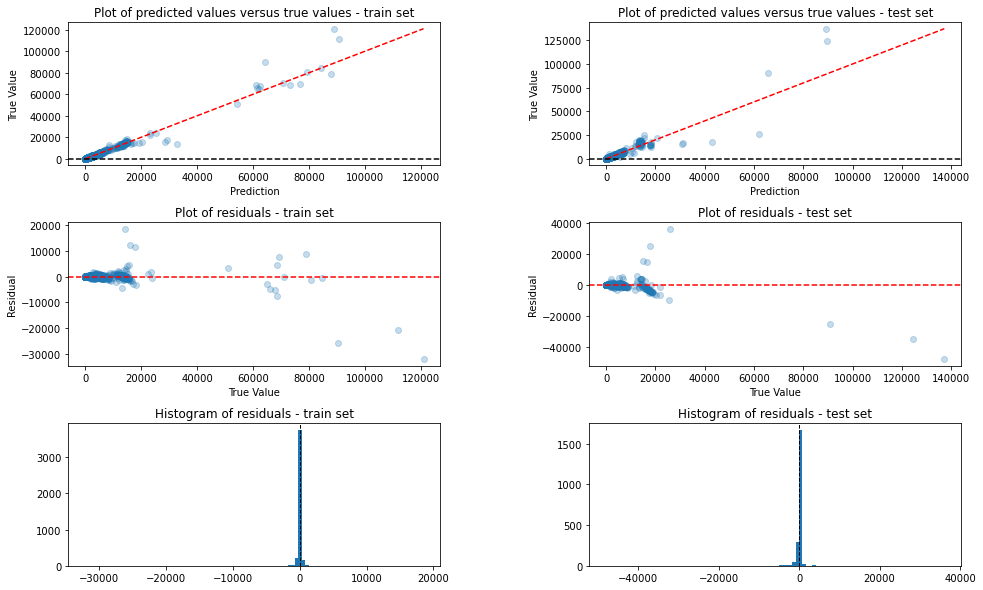

RMSE train: 888.8452924254968
DPA  train: 92.20653034831076
BIAS train: -0.19958740982361153

RMSE test:  1906.3767235110513
DPA  test: 83.32877099116632
BIAS test: -4.047806473823817


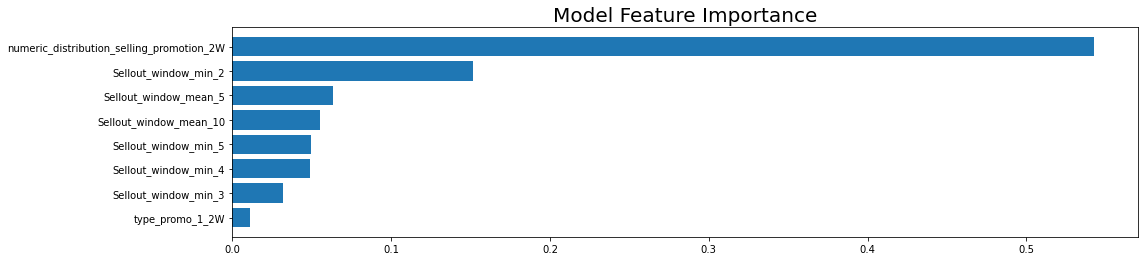

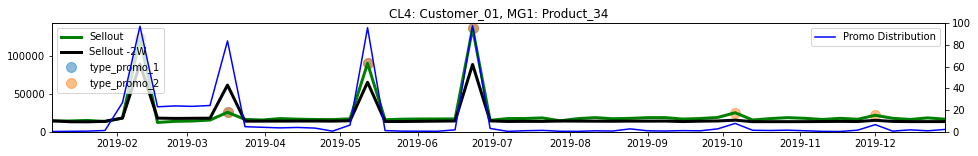

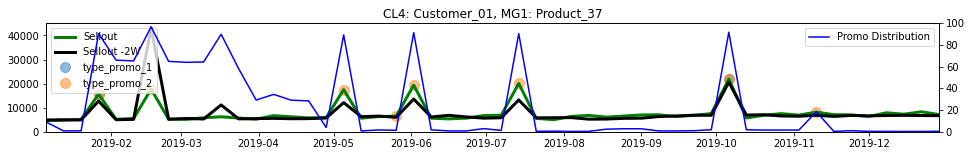

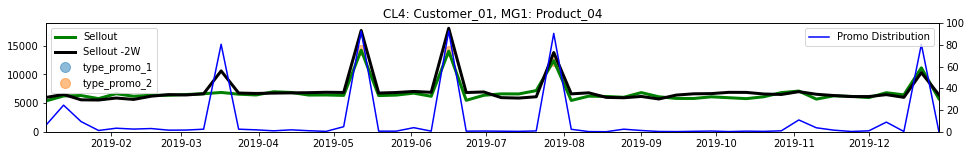

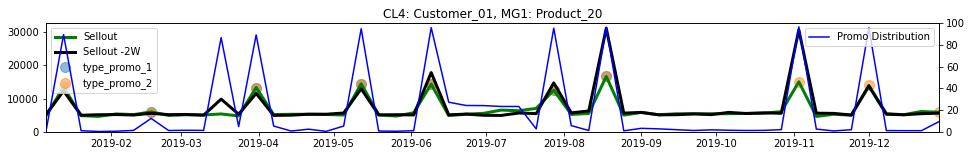

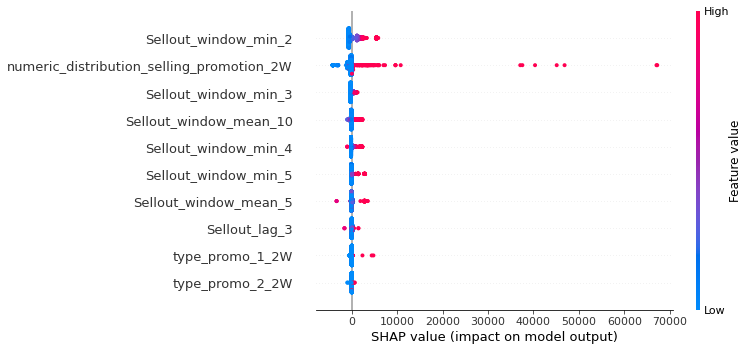

None

Finished iterating in: 20 seconds


|---------------------------	Sellout_3W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_3W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_3W', 'type_promo_1_3W', 'type_promo_2_3W', 'Sellout', 'Sellout_lag_1', 'Sellout_lag_2', 'Sellout_lag_3', 'Sellout_lag_4', 'Sellout_lag_5', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_2', 'Sellout_window_std_3', 'Sellout_window_std_4', 'Sellout_window_std_5', 'Sellout_window_min_2', 'Sellout_window_min_3', 'Sellout_window_min_4', 'Sellout_window_min_5', 'Sellout_window_max_2', 'Sellout_window_max_3', 'Sellout_window_max_4', 'Sellout_window_max_5']
Number: 29


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   

            numeric_distribution_selling_promotion_3W  type_promo_1_3W  \
PERIOD_TAG                                                               
2016-10-09                                        0.0              0.0   
2016-10-16                                        0.0              0.0   
2016-10-23                                        0.0              0.0   
2016-10-30                                        0.8              0.0   
2016-11-06                                        0.1              0.0   
...                                               ...              ...   
2018-11-11                                        0.6              0.0   
2018-11-18                                        0.5              0.0   
2018-11-25                                        0.6              0.0   
2018-12-02                                        0.5              0.0   
2018-12-09                                       78.1              0.0   

            type_promo_2_3W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2016-10-09              0.0   108.944085     122.284177     106.720737   
2016-10-16              0.0   106.720737     108.944085     122.284177   
2016-10-23              0.0   105.609062     106.720737     108.944085   
2016-10-30              0.0   118.949154     105.609062     106.720737   
2016-11-06              0.0    86.710598     118.949154     105.609062   
...                     ...          ...            ...            ...   
2018-11-11              0.0  2276.098555    2683.899546    2440.878607   
2018-11-18              0.0  2444.435011    2276.098555    2683.899546   
2018-11-25              0.0  2241.719983    2444.435011    2276.098555   
2018-12-02              0.0  1974.989684    2241.719983    2444.435011   
2018-12-09              0.0  1816.136972    1974.989684    2241.719983   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2016-10-09     110.055760  ...              6.994131             40.845523   
2016-10-16     106.720737  ...              7.484907              6.501157   
2016-10-23     122.284177  ...              7.721937              6.942404   
2016-10-30     108.944085  ...              6.088891              7.596893   
2016-11-06     106.720737  ...             13.309176             11.696378   
...                   ...  ...                   ...                   ...   
2018-11-11    5852.655503  ...           1701.115046           1473.353930   
2018-11-18    2440.878607  ...            167.880504           1523.600486   
2018-11-25    2683.899546  ...            202.027248            175.452067   
2018-12-02    2276.098555  ...            194.251330            262.156806   
2018-12-09    2444.435011  ...            278.946061            251.543348   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2016-10-09            108.944085            106.720737            106.720737   
2016-10-16            106.720737     

PERIOD_TAG
2016-10-09     118.949154
2016-10-16      86.710598
2016-10-23      96.715668
2016-10-30      95.603993
2016-11-06      97.827342
                 ...     
2018-11-11    1974.989684
2018-11-18    1816.136972
2018-11-25    1632.389432
2018-12-02    1653.727856
2018-12-09    3072.733049
Name: Sellout_3W, Length: 4180, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
...              ...       ...                        ...   
2019-11-03 -0.875735  0.482792                          1   
2019-11-10 -0.812487  0.582979                          1   
2019-11-17 -0.737833  0.674983                          1   
2019-11-24 -0.652822  0.757511                          1   
2019-12-01 -0.558647  0.829406                          1   

            numeric_distribution_selling_promotion_3W  type_promo_1_3W  \
PERIOD_TAG                                                               
2018-12-16                                        0.0              0.0   
2018-12-23                                        0.0              0.0   
2018-12-30                                        0.0              0.0   
2019-01-06                                        0.0              0.0   
2019-01-13                                        0.0              0.0   
...                                               ...              ...   
2019-11-03                                        0.5              0.0   
2019-11-10                                        1.0              0.0   
2019-11-17                                        0.8              0.0   
2019-11-24                                        0.5              0.0   
2019-12-01                                       66.1              0.0   

            type_promo_2_3W      Sellout  Sellout_lag_1  Sellout_lag_2  \
PERIOD_TAG                                                               
2018-12-16              0.0   212.329799     131.177572     137.847618   
2018-12-23              0.0   121.172503     212.329799     131.177572   
2018-12-30              0.0   155.634407     121.172503     212.329799   
2019-01-06              0.0   126.730875     155.634407     121.172503   
2019-01-13              0.0   123.395852     126.730875     155.634407   
...                     ...          ...            ...            ...   
2019-11-03              0.0  1595.639924    1736.710616    1573.116032   
2019-11-10              0.0  1345.506177    1595.639924    1736.710616   
2019-11-17              0.0  1437.972681    1345.506177    1595.639924   
2019-11-24              0.0  1377.513813    1437.972681    1345.506177   
2019-12-01              0.0  1320.611349    1377.513813    1437.972681   

            Sellout_lag_3  ...  Sellout_window_std_4  Sellout_window_std_5  \
PERIOD_TAG                 ...                                               
2018-12-16     121.172503  ...             41.698903             39.767809   
2018-12-23     137.847618  ...             41.698903             38.440471   
2018-12-30     131.177572  ...             40.820302             36.181542   
2019-01-06     212.329799  ...             41.738400             37.555841   
2019-01-13     121.172503  ...             16.096901             38.645676   
...                   ...  ...                   ...                   ...   
2019-11-03    1575.486968  ...             78.302981             91.278726   
2019-11-10    1573.116032  ...            161.911886            140.335579   
2019-11-17    1736.710616  ...            172.762388            150.914313   
2019-11-24    1595.639924  ...            111.143552            164.232034   
2019-12-01    1345.506177  ...             50.712542            109.887832   

            Sellout_window_min_2  Sellout_window_min_3  Sellout_window_min_4  \
PERIOD_TAG                                                                     
2018-12-16            131.177572            131.177572            121.172503   
2018-12-23            121.172503     

PERIOD_TAG
2018-12-16     126.730875
2018-12-23     123.395852
2018-12-30     131.177572
2019-01-06     125.619200
2019-01-13     141.182641
                 ...     
2019-11-03    1377.513813
2019-11-10    1320.611349
2019-11-17    1626.462092
2019-11-24    1509.100761
2019-12-01    2568.909150
Name: Sellout_3W, Length: 2091, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-19283000.601031493

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


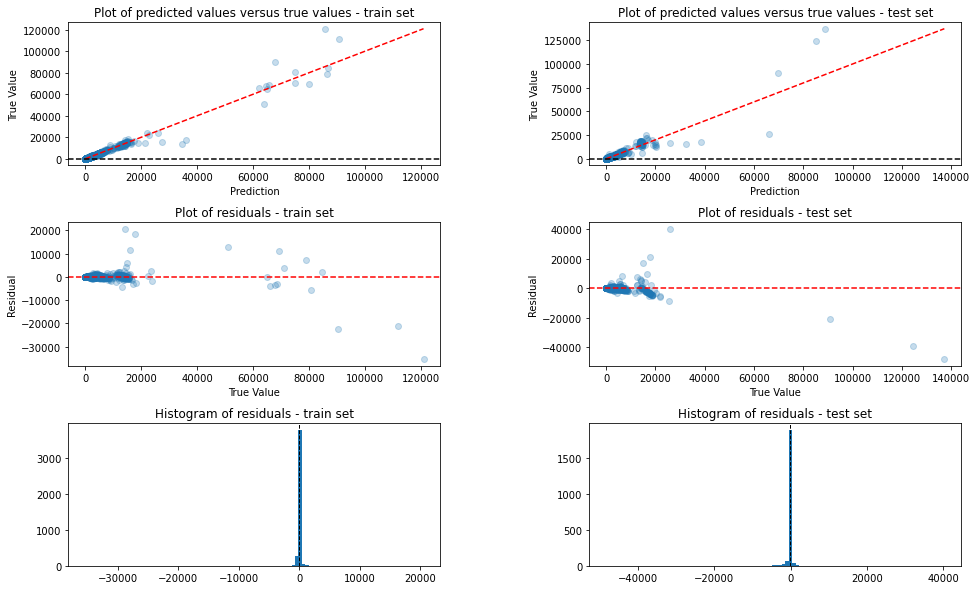

RMSE train: 948.4006508331062
DPA  train: 92.91702921378258
BIAS train: 0.3472137649447574

RMSE test:  1936.295325208373
DPA  test: 83.43102200285935
BIAS test: -3.5229007711004114


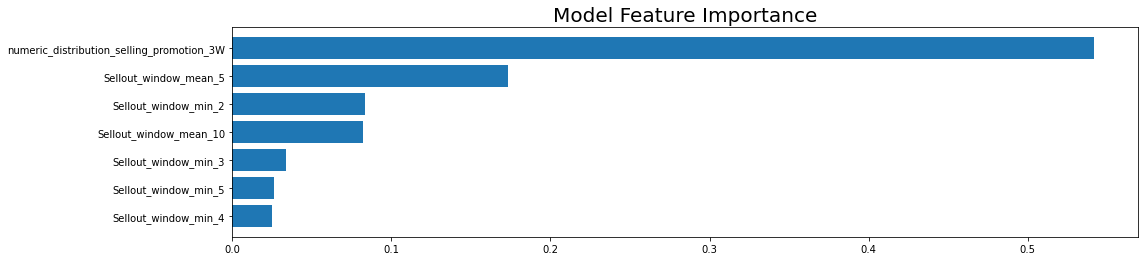

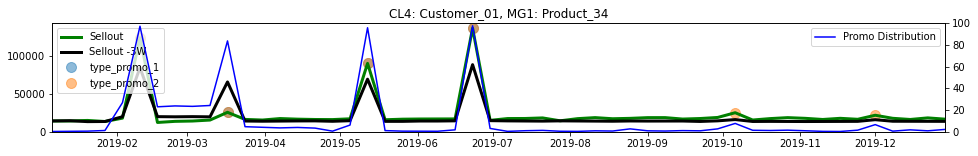

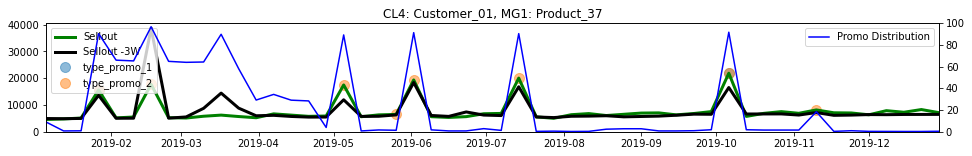

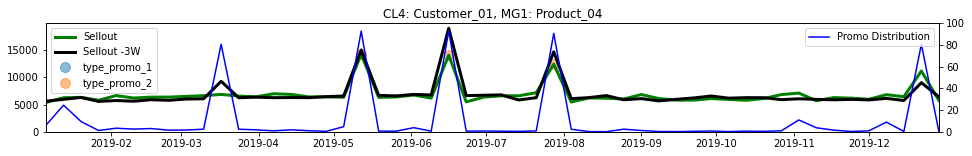

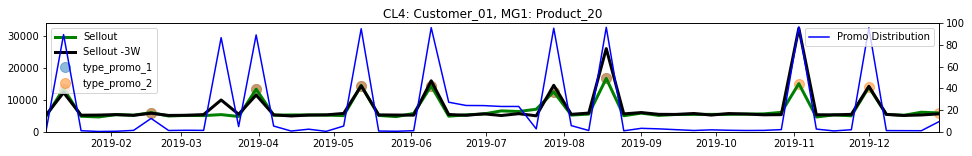

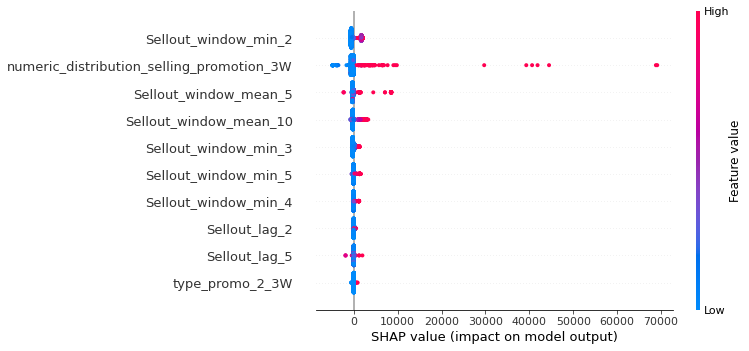

None

Finished iterating in: 20 seconds


|---------------------------	Sellout_4W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_4W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_4W', 'type_promo_1_4W', 'type_promo_2_4W', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_10', 'Sellout_window_min_10', 'Sellout_window_max_10']
Number: 14
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-19872229.547054946

The best parameters: 
{'

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-18 -0.737833  0.674983                          1   
2018-10-28 -0.926690  0.375828                          1   
2018-11-04 -0.875735  0.482792                          1   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   

            numeric_distribution_selling_promotion_6W  type_promo_1_6W  \
PERIOD_TAG                                                               
2016-10-09                                        0.8              0.0   
2016-10-16                                        0.1              0.0   
2016-10-23                                        0.0              0.0   
2016-10-30                                        0.0              0.0   
2016-11-06                                        0.0              0.0   
...                                               ...              ...   
2018-11-18                                        0.2              0.0   
2018-10-28                                        0.5              0.0   
2018-11-04                                        0.6              0.0   
2018-11-11                                        0.5              0.0   
2018-11-18                                       78.1              0.0   

            type_promo_2_6W  Sellout_window_mean_5  Sellout_window_mean_10  \
PERIOD_TAG                                                                   
2016-10-09              0.0             130.065898              106.720737   
2016-10-16              0.0             110.945099              117.392810   
2016-10-23              0.0             110.055760              117.726313   
2016-10-30              0.0             112.501443              120.283164   
2016-11-06              0.0             105.386727              118.837987   
...                     ...                    ...                     ...   
2018-11-18              0.0             231.979489              272.582225   
2018-10-28              0.0            2578.155801             1289.077900   
2018-11-04              0.0            3114.935710             1557.467855   
2018-11-11              0.0            3304.136402             1785.077710   
2018-11-18              0.0            3139.593444             2029.521211   

            Sellout_window_std_10  Sellout_window_min_10  \
PERIOD_TAG                                                 
2016-10-09              48.527553               0.000000   
2016-10-16              31.030564              93.380644   
2016-10-23              30.867513              93.380644   
2016-10-30              29.662245             101.162365   
2016-11-06              31.018392              86.710598   
...                           ...                    ...   
2018-11-18              66.433442             193.527055   
2018-10-28            2001.046039               0.000000   
2018-11-04            1988.889728               0.000000   
2018-11-11            1919.890120               0.000000   
2018-11-18            1820.394525               0.000000   

            Sellout_window_max_10  
PERIOD_TAG                         
2016-10-09             202.324730  
2016-10-16             202.324730  
2016-10-23             202.324730  
2016-10-30             202.324730  
2016-11-06             202.324730  
...                           ...  
2018-11-18             360.491573  
2018-10-28            5852.655503  
2018-11-04            5852.655503  
2018-11-11            5852.655503  
2018-11-18            5852.

PERIOD_TAG
2016-10-09      95.603993
2016-10-16      97.827342
2016-10-23     105.609062
2016-10-30     102.274039
2016-11-06     105.609062
                 ...     
2018-11-18     263.095604
2018-10-28    1816.136972
2018-11-04    1632.389432
2018-11-11    1653.727856
2018-11-18    3072.733049
Name: Sellout_6W, Length: 4057, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   
...              ...       ...                        ...   
2019-10-13 -0.989040  0.147647                          1   
2019-10-20 -0.964636  0.263587                          1   
2019-10-27 -0.926690  0.375828                          1   
2019-11-03 -0.875735  0.482792                          1   
2019-11-10 -0.812487  0.582979                          1   

            numeric_distribution_selling_promotion_6W  type_promo_1_6W  \
PERIOD_TAG                                                               
2018-11-25                                        0.0              0.0   
2018-12-02                                        0.0              0.0   
2018-12-09                                        0.0              0.0   
2018-12-16                                        0.0              0.0   
2018-12-23                                        0.0              0.0   
...                                               ...              ...   
2019-10-13                                        0.5              0.0   
2019-10-20                                        1.0              0.0   
2019-10-27                                        0.8              0.0   
2019-11-03                                        0.5              0.0   
2019-11-10                                       66.1              0.0   

            type_promo_2_6W  Sellout_window_mean_5  Sellout_window_mean_10  \
PERIOD_TAG                                                                   
2018-11-25              0.0             123.395852              130.510567   
2018-12-02              0.0             129.398893              132.956251   
2018-12-09              0.0             129.398893              132.956251   
2018-12-16              0.0             143.183655              135.290767   
2018-12-23              0.0             144.739999              134.290260   
...                     ...                    ...                     ...   
2019-10-13              0.0            1730.783276             1786.263178   
2019-10-20              0.0            1701.857857             1765.043301   
2019-10-27              0.0            1690.477364             1760.064336   
2019-11-03              0.0            1647.563423             1749.632217   
2019-11-10              0.0            1565.291944             1672.813891   

            Sellout_window_std_10  Sellout_window_min_10  \
PERIOD_TAG                                                 
2018-11-25              23.154397             107.832411   
2018-12-02              22.425349             107.832411   
2018-12-09              22.425349             107.832411   
2018-12-16              29.121483             107.832411   
2018-12-23              29.448531             107.832411   
...                           ...                    ...   
2019-10-13             136.071209            1575.486968   
2019-10-20             151.864831            1573.116032   
2019-10-27             151.899374            1573.116032   
2019-11-03             159.859479            1573.116032   
2019-11-10             149.727575            1345.506177   

            Sellout_window_max_10  
PERIOD_TAG                         
2018-11-25             188.984638  
2018-12-02             188.984638  
2018-12-09             188.984638  
2018-12-16             212.329799  
2018-12-23             212.329799  
...                           ...  
2019-10-13            2113.689439  
2019-10-20            2113.689439  
2019-10-27            2113.689439  
2019-11-03            2113.689439  
2019-11-10            1823.

PERIOD_TAG
2018-11-25     126.730875
2018-12-02     123.395852
2018-12-09     131.177572
2018-12-16     125.619200
2018-12-23     141.182641
                 ...     
2019-10-13    1377.513813
2019-10-20    1320.611349
2019-10-27    1626.462092
2019-11-03    1509.100761
2019-11-10    2568.909150
Name: Sellout_6W, Length: 2091, dtype: float64

--------------------------------------------------------

Evaluation charts


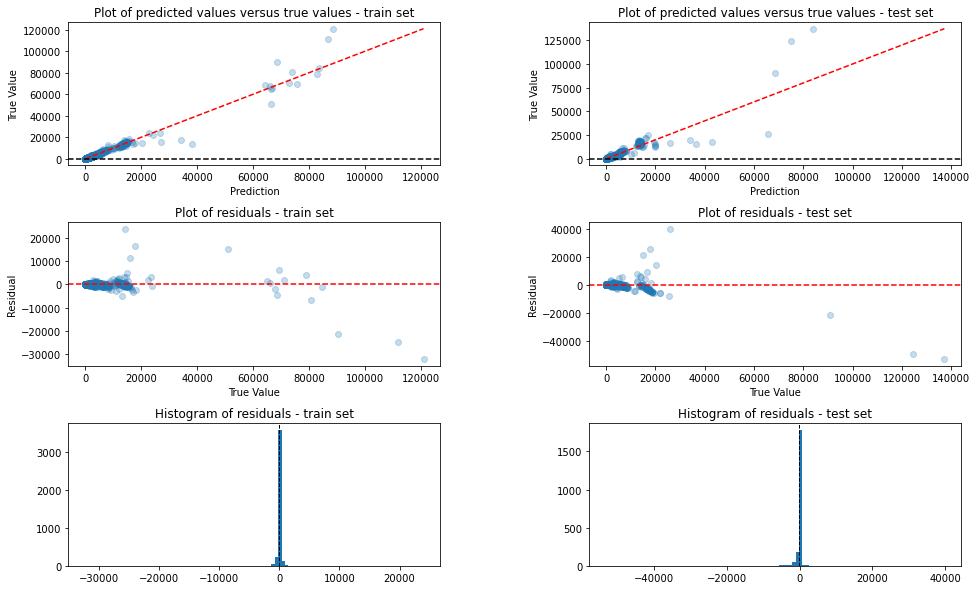

RMSE train: 965.4630354691302
DPA  train: 91.29798707003249
BIAS train: 0.019680593695708248

RMSE test:  2181.2116874905937
DPA  test: 80.5818409848416
BIAS test: -4.9861868203484905


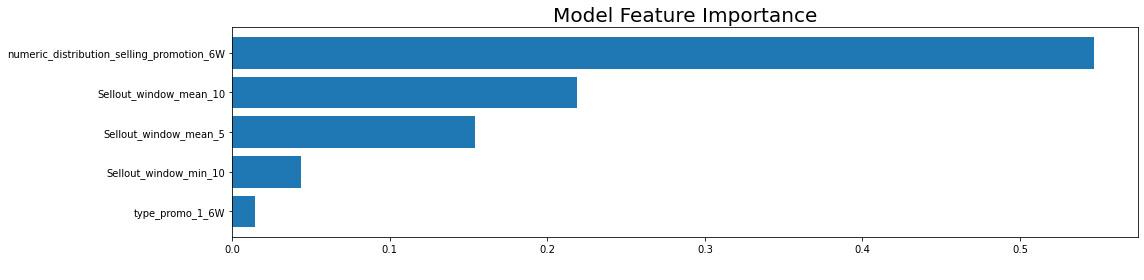

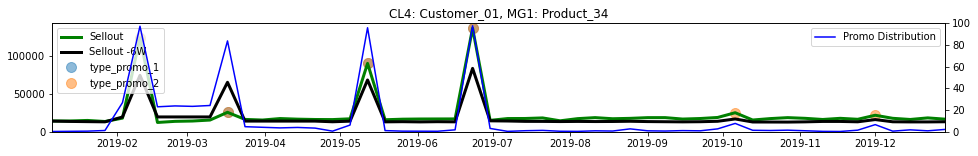

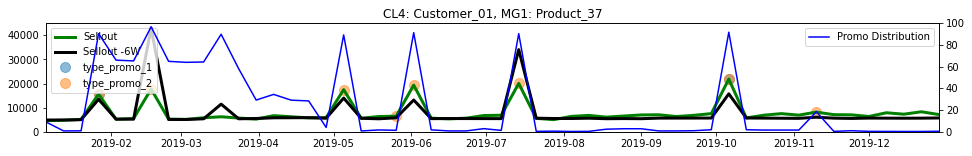

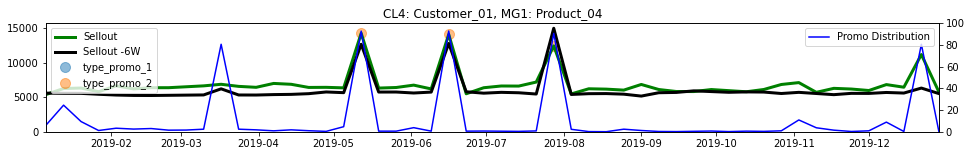

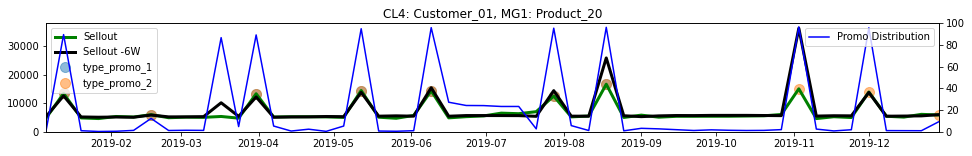

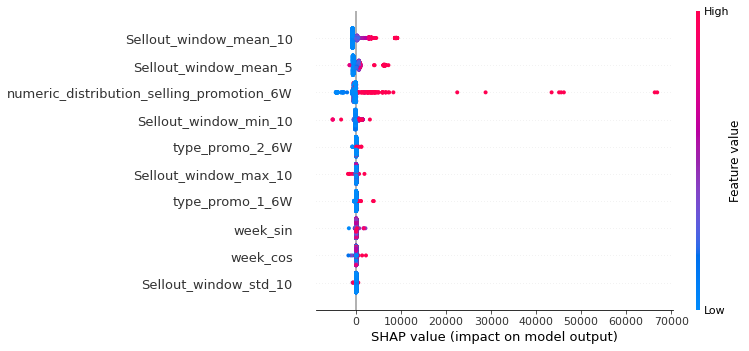

None

Finished iterating in: 5 seconds


|---------------------------	Sellout_7W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_7W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_7W', 'type_promo_1_7W', 'type_promo_2_7W', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_10', 'Sellout_window_min_10', 'Sellout_window_max_10']
Number: 14
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Finished iterating in: 2 seconds


|---------------------------	Sellout_8W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_8W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Cu

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-09-23 -0.978556 -0.205979                          1   
2018-09-30 -0.996050 -0.088796                          1   
2018-10-07 -0.999561  0.029633                          1   
2018-10-14 -0.989040  0.147647                          1   
2018-10-21 -0.964636  0.263587                          1   

            numeric_distribution_selling_promotion_10W  type_promo_1_10W  \
PERIOD_TAG                                                                 
2016-10-09                                         0.0               0.0   
2016-10-16                                         0.0               0.0   
2016-10-23                                         0.0               0.0   
2016-10-30                                         0.0               0.0   
2016-11-06                                         0.9               0.0   
...                                                ...               ...   
2018-09-23                                         0.1               0.0   
2018-09-30                                         0.3               0.0   
2018-10-07                                         0.1               0.0   
2018-10-14                                         0.7               0.0   
2018-10-21                                         0.2               0.0   

            type_promo_2_10W  Sellout_window_mean_5  Sellout_window_mean_10  \
PERIOD_TAG                                                                    
2016-10-09               0.0             130.065898              106.720737   
2016-10-16               0.0             110.945099              117.392810   
2016-10-23               0.0             110.055760              117.726313   
2016-10-30               0.0             112.501443              120.283164   
2016-11-06               0.0             105.386727              118.837987   
...                      ...                    ...                     ...   
2018-09-23               0.0             301.801015              306.481081   
2018-09-30               0.0             308.125429              310.149241   
2018-10-07               0.0             303.065898              316.600143   
2018-10-14               0.0             313.184960              314.449842   
2018-10-21               0.0             320.774256              315.714725   

            Sellout_window_std_10  Sellout_window_min_10  \
PERIOD_TAG                                                 
2016-10-09              48.527553               0.000000   
2016-10-16              31.030564              93.380644   
2016-10-23              30.867513              93.380644   
2016-10-30              29.662245             101.162365   
2016-11-06              31.018392              86.710598   
...                           ...                    ...   
2018-09-23              40.643017             227.678888   
2018-09-30              41.861482             227.678888   
2018-10-07              31.405170             263.095604   
2018-10-14              26.833539             263.095604   
2018-10-21              28.247159             263.095604   

            Sellout_window_max_10  
PERIOD_TAG                         
2016-10-09             202.324730  
2016-10-16             202.324730  
2016-10-23             202.324730  
2016-10-30             202.324730  
2016-11-06             202.324730  
...                           ...  
2018-09-23             381.994579  
2018-09-30             381.994579  
2018-10-07             381.994579  
2018-10-14             3

PERIOD_TAG
2016-10-09    105.609062
2016-10-16     94.492319
2016-10-23     92.268970
2016-10-30    102.274039
2016-11-06    110.055760
                 ...    
2018-09-23    225.149123
2018-09-30    237.797950
2018-10-07    212.500296
2018-10-14    213.765178
2018-10-21    263.095604
Name: Sellout_10W, Length: 3893, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-10-28 -0.926690  0.375828                          1   
2018-11-04 -0.875735  0.482792                          1   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
...              ...       ...                        ...   
2019-09-15 -0.947326 -0.320270                          1   
2019-09-22 -0.978556 -0.205979                          1   
2019-09-29 -0.996050 -0.088796                          1   
2019-10-06 -0.999561  0.029633                          1   
2019-10-13 -0.989040  0.147647                          1   

            numeric_distribution_selling_promotion_10W  type_promo_1_10W  \
PERIOD_TAG                                                                 
2018-10-28                                         0.0               0.0   
2018-11-04                                         0.0               0.0   
2018-11-11                                         0.0               0.0   
2018-11-18                                         0.0               0.0   
2018-11-25                                         0.0               0.0   
...                                                ...               ...   
2019-09-15                                         0.5               0.0   
2019-09-22                                         1.0               0.0   
2019-09-29                                         0.8               0.0   
2019-10-06                                         0.5               0.0   
2019-10-13                                        66.1               0.0   

            type_promo_2_10W  Sellout_window_mean_5  Sellout_window_mean_10  \
PERIOD_TAG                                                                    
2018-10-28               0.0             136.513609              136.735944   
2018-11-04               0.0             136.513609              129.732395   
2018-11-11               0.0             127.397879              131.066405   
2018-11-18               0.0             123.840521              130.510567   
2018-11-25               0.0             123.395852              130.510567   
...                      ...                    ...                     ...   
2019-09-15               0.0            1828.228746             1879.559510   
2019-09-22               0.0            1829.651307             1821.708672   
2019-09-29               0.0            1851.701012             1794.798548   
2019-10-06               0.0            1780.335838             1802.266996   
2019-10-13               0.0            1730.783276             1786.263178   

            Sellout_window_std_10  Sellout_window_min_10  \
PERIOD_TAG                                                 
2018-10-28              31.816250             107.832411   
2018-11-04              22.344685             107.832411   
2018-11-11              22.761138             107.832411   
2018-11-18              23.154397             107.832411   
2018-11-25              23.154397             107.832411   
...                           ...                    ...   
2019-09-15             230.022374            1682.179088   
2019-09-22             151.838712            1682.179088   
2019-09-29             122.032208            1682.179088   
2019-10-06             116.535584            1699.961108   
2019-10-13             136.071209            1575.486968   

            Sellout_window_max_10  
PERIOD_TAG                         
2018-10-28             201.213055  
2018-11-04             188.984638  
2018-11-11             188.984638  
2018-11-18             188.984638  
2018-11-25             188.984638  
...                           ...  
2019-09-15            2372.121463  
2019-09-22            2113.689439  
2019-09-29            2113.689439  
2019-10-06            21

PERIOD_TAG
2018-10-28     126.730875
2018-11-04     123.395852
2018-11-11     131.177572
2018-11-18     125.619200
2018-11-25     141.182641
                 ...     
2019-09-15    1377.513813
2019-09-22    1320.611349
2019-09-29    1626.462092
2019-10-06    1509.100761
2019-10-13    2568.909150
Name: Sellout_10W, Length: 2091, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-20101147.07518796

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


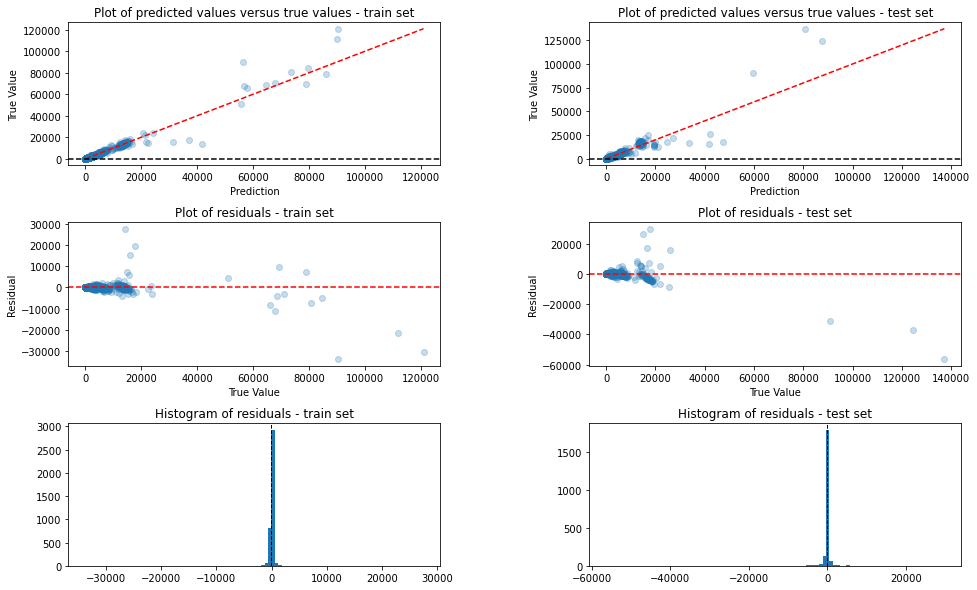

RMSE train: 1107.1595416029559
DPA  train: 90.10520384453771
BIAS train: -0.3557650438433665

RMSE test:  2067.5481080880336
DPA  test: 80.1117182599173
BIAS test: -2.4227283541052085


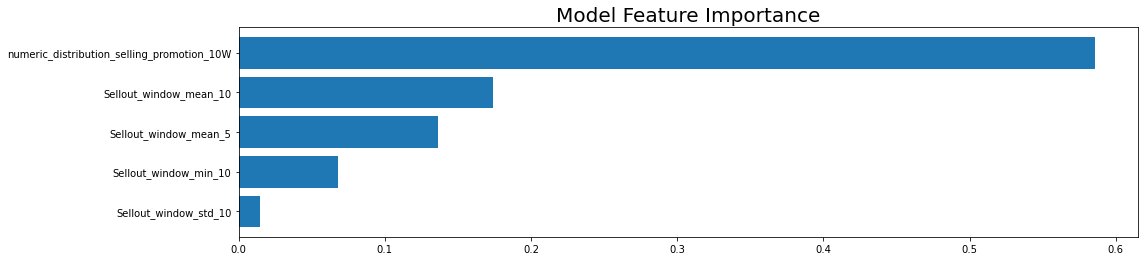

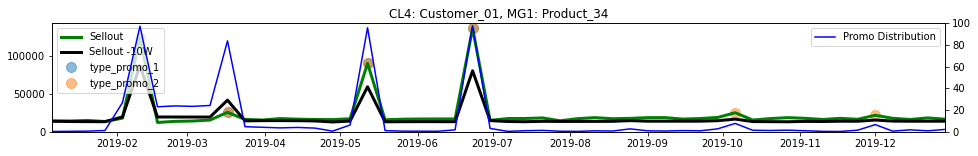

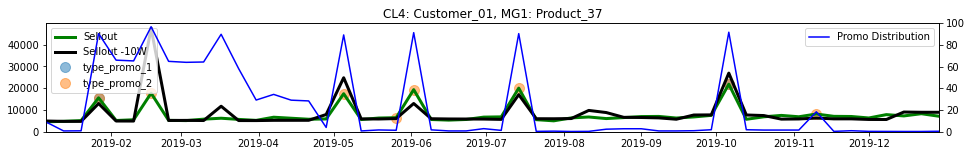

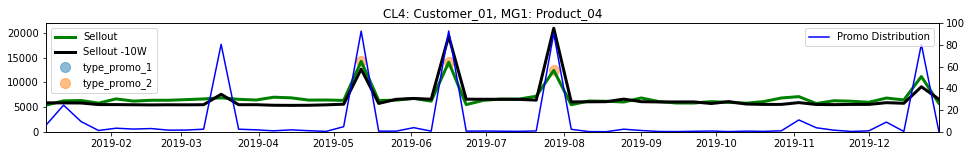

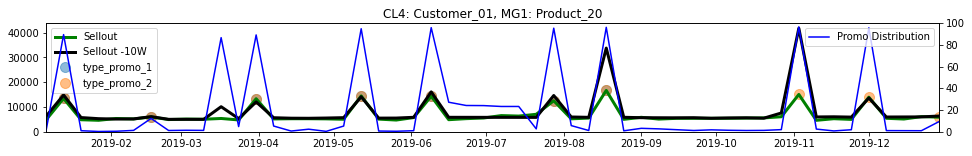

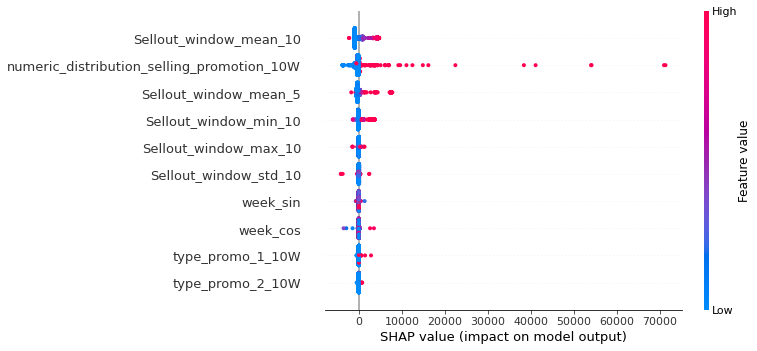

None

Finished iterating in: 10 seconds


|---------------------------	Sellout_11W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_11W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'numeric_distribution_selling_promotion_11W', 'type_promo_1_11W', 'type_promo_2_11W', 'Sellout_window_mean_5', 'Sellout_window_mean_10', 'Sellout_window_std_10', 'Sellout_window_min_10', 'Sellout_window_max_10']
Number: 14
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Finished iterating in: 3 seconds


|---------------------------	Sellout_12W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['Sellout_12W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   

            Prediction_Sellout_2W  Prediction_Sellout_3W  \
PERIOD_TAG                                                 
2016-10-09             119.335008             119.860978   
2016-10-16             119.315849             103.939716   
2016-10-23             109.647681             103.786447   
2016-10-30             109.775275             106.283586   
2016-11-06             102.431278             100.525397   
...                           ...                    ...   
2018-11-25            2232.875128            1967.414115   
2018-12-02            2144.737377            1946.179258   
2018-12-09            1931.318177            4277.816497   
2018-12-16            3869.300898            1891.809533   
2018-12-23            1829.628626            1895.156510   

            Prediction_Sellout_4W  Prediction_Sellout_5W  orders_SellIn  \
PERIOD_TAG                                                                
2016-10-09             123.632893             112.294252            164   
2016-10-16             114.581641             106.886399            131   
2016-10-23             104.601230             103.804024             59   
2016-10-30             118.972864             111.830400            205   
2016-11-06              78.789461             100.102375            187   
...                           ...                    ...            ...   
2018-11-25            2197.994364            4402.439317            345   
2018-12-02            4766.370994            2308.126712            864   
2018-12-09            2326.266063            2143.413008           1900   
2018-12-16            2318.155421            2071.493190           2894   
2018-12-23            2265.036910            2099.687539            734   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2016-10-09                  0.0                260.0  ...   
2016-10-16                164.0                  0.0  ...   
2016-10-23                131.0                164.0  ...   
2016-10-30                 59.0                131.0  ...   
2016-11-06                205.0                 59.0  ...   
...                         ...                  ...  ...   
2018-11-25                993.0                950.0  ...   
2018-12-02                345.0                993.0  ...   
2018-12-09                864.0                345.0  ...   
2018-12-16               1900.0                864.0  ...   
2018-12-23               2894.0               1900.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2016-10-09                      107.472089                       93.122500   
2016-10-16                      107.472089                       93.138070   
2016-10-23                       73.505102                       99.672965   
2016-10-30                       61.759615                       82.259954   
2016-11-06                       65.714027                       57.508260   
...                                    ...                             ...   
2018-11-25                     1189.545677 

PERIOD_TAG
2016-10-09     131.0
2016-10-16      59.0
2016-10-23     205.0
2016-10-30     187.0
2016-11-06       1.0
               ...  
2018-11-25     864.0
2018-12-02    1900.0
2018-12-09    2894.0
2018-12-16     734.0
2018-12-23    1900.0
Name: orders_SellIn_1W, Length: 4262, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
2019-01-20  0.348202  0.937420                          1   
2019-01-27  0.456629  0.889657                          1   
...              ...       ...                        ...   
2019-07-28 -0.403123 -0.915146                          1   
2019-08-04 -0.508531 -0.861044                          1   
2019-08-11 -0.606800 -0.794854                          1   
2019-08-18 -0.696551 -0.717507                          1   
2019-08-25 -0.776524 -0.630088                          1   

            Prediction_Sellout_2W  Prediction_Sellout_3W  \
PERIOD_TAG                                                 
2018-12-30             145.123173             143.815717   
2019-01-06             146.636684             133.624922   
2019-01-13             133.957598             144.438021   
2019-01-20             140.528747             137.788869   
2019-01-27             134.043076             132.218906   
...                           ...                    ...   
2019-07-28            1835.188039            1720.147375   
2019-08-04            1827.335353            1864.852181   
2019-08-11            1861.375488            1847.803544   
2019-08-18            1899.424025            1831.449830   
2019-08-25            1818.589710            1864.003901   

            Prediction_Sellout_4W  Prediction_Sellout_5W  orders_SellIn  \
PERIOD_TAG                                                                
2018-12-30             136.770408             143.988202            403   
2019-01-06             136.770408             142.761235              2   
2019-01-13             136.770408             142.945351            116   
2019-01-20             123.632893             120.912557            231   
2019-01-27             123.632893             123.072017             57   
...                           ...                    ...            ...   
2019-07-28            1964.620058            1856.147181           2937   
2019-08-04            2044.114409            1855.754151           2160   
2019-08-11            1633.930317            1868.168561           1864   
2019-08-18            1580.811806            1780.505329           1209   
2019-08-25            1564.433839            1641.807948            738   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2018-12-30                 59.0                  0.0  ...   
2019-01-06                403.0                 59.0  ...   
2019-01-13                  2.0                403.0  ...   
2019-01-20                116.0                  2.0  ...   
2019-01-27                231.0                116.0  ...   
...                         ...                  ...  ...   
2019-07-28               3247.0               1561.0  ...   
2019-08-04               2937.0               3247.0  ...   
2019-08-11               2160.0               2937.0  ...   
2019-08-18               1864.0               2160.0  ...   
2019-08-25               1209.0               1864.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2018-12-30                      183.948136                      174.226003   
2019-01-06                      193.278728                      169.314205   
2019-01-13                      178.185297                      167.384288   
2019-01-20                      171.127633                      159.033644   
2019-01-27                       98.083298                      159.360284   
...                                    ...                             ...   
2019-07-28                     1028.080858 

PERIOD_TAG
2018-12-30       2.0
2019-01-06     116.0
2019-01-13     231.0
2019-01-20      57.0
2019-01-27     173.0
               ...  
2019-07-28    2160.0
2019-08-04    1864.0
2019-08-11    1209.0
2019-08-18     738.0
2019-08-25    1040.0
Name: orders_SellIn_1W, Length: 1435, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=7,
                                       n_jobs=3, random_state=123))])

The best score: 
-16823752.147551853

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 7, 'regressor__n_estimators': 100}

Evaluation charts


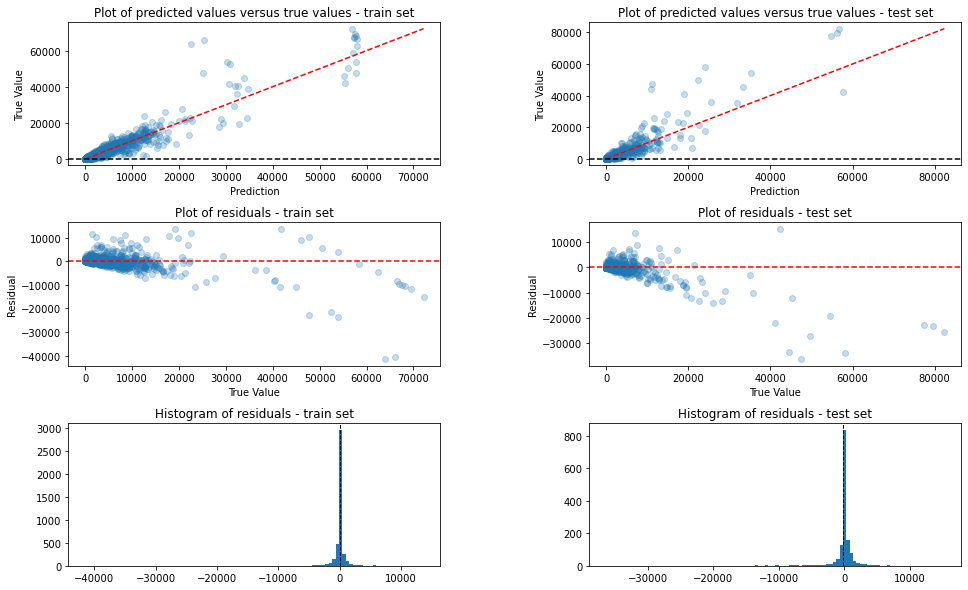

RMSE train: 1590.178274381354
DPA  train: 74.51063007007605
BIAS train: -0.20425303433438952

RMSE test:  2771.417424092395
DPA  test: 59.88684173454376
BIAS test: -7.770150049925921


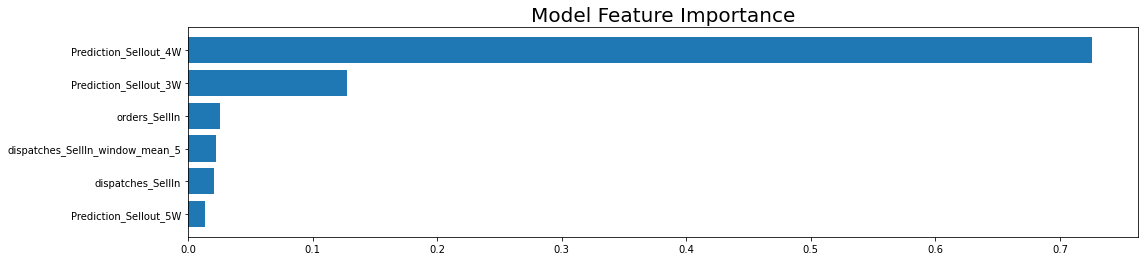

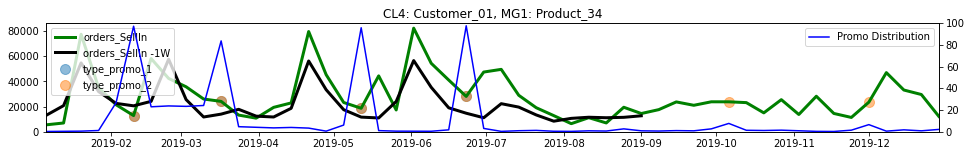

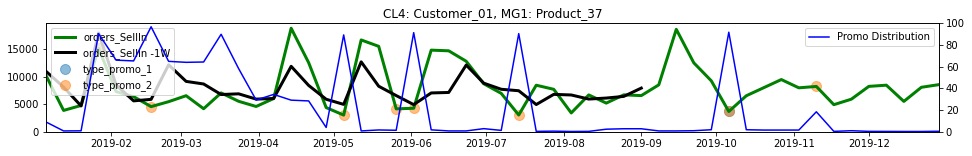

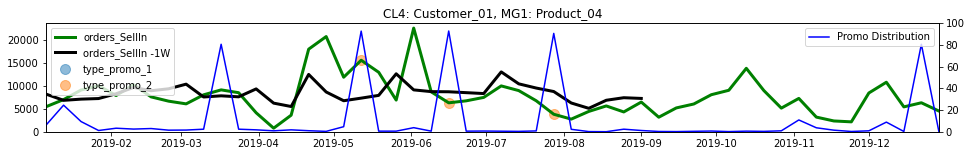

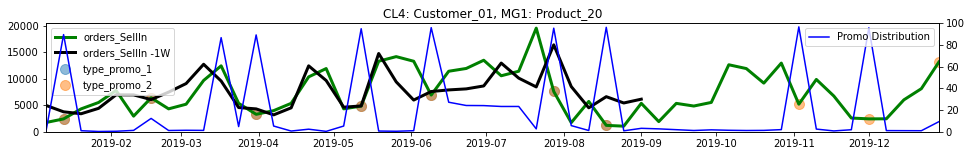

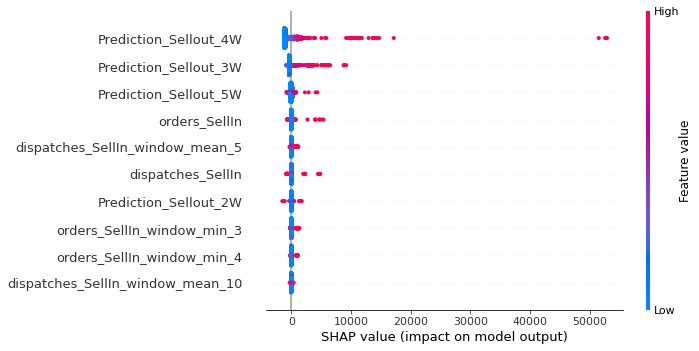

None

Finished iterating in: 36 seconds


|---------------------------	orders_SellIn_2W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['orders_SellIn_2W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'Prediction_Sellout_3W', 'Prediction_Sellout_4W', 'Prediction_Sellout_5W', 'Prediction_Sellout_6W', 'orders_SellIn', 'orders_SellIn_lag_1', 'orders_SellIn_lag_2', 'orders_SellIn_lag_3', 'orders_SellIn_lag_4', 'orders_SellIn_lag_5', 'dispatches_SellIn', 'dispatches_SellIn_lag_1', 'dispatches_SellIn_lag_2', 'dispatches_SellIn_lag_3', 'dispatches_SellIn_lag_4', 'dispatches_SellIn_lag_5', 'orders_SellIn_window_std_2', 'orders_SellIn_window_std_3', 'orders_SellIn_window_std_4', 'orders_SellIn_window_std_5', 'orders_SellIn_window_min_2', 'orders_SellIn_window_min_3', 'orders_SellIn_window_min_4', 'orders_SellIn_window_min_5', 'orders_SellIn_window_max_2', 

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   

            Prediction_Sellout_3W  Prediction_Sellout_4W  \
PERIOD_TAG                                                 
2016-10-09             119.860978             123.632893   
2016-10-16             103.939716             114.581641   
2016-10-23             103.786447             104.601230   
2016-10-30             106.283586             118.972864   
2016-11-06             100.525397              78.789461   
...                           ...                    ...   
2018-11-18            2018.431141            1739.343621   
2018-11-25            1967.414115            2197.994364   
2018-12-02            1946.179258            4766.370994   
2018-12-09            4277.816497            2326.266063   
2018-12-16            1891.809533            2318.155421   

            Prediction_Sellout_5W  Prediction_Sellout_6W  orders_SellIn  \
PERIOD_TAG                                                                
2016-10-09             112.294252             111.734901            164   
2016-10-16             106.886399             107.653771            131   
2016-10-23             103.804024             104.347765             59   
2016-10-30             111.830400             107.666545            205   
2016-11-06             100.102375             100.520099            187   
...                           ...                    ...            ...   
2018-11-18            1814.427083            4524.068715            993   
2018-11-25            4402.439317            2297.195904            345   
2018-12-02            2308.126712            2399.756887            864   
2018-12-09            2143.413008            1983.603607           1900   
2018-12-16            2071.493190            2044.598491           2894   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2016-10-09                  0.0                260.0  ...   
2016-10-16                164.0                  0.0  ...   
2016-10-23                131.0                164.0  ...   
2016-10-30                 59.0                131.0  ...   
2016-11-06                205.0                 59.0  ...   
...                         ...                  ...  ...   
2018-11-18                950.0               3067.0  ...   
2018-11-25                993.0                950.0  ...   
2018-12-02                345.0                993.0  ...   
2018-12-09                864.0                345.0  ...   
2018-12-16               1900.0                864.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2016-10-09                      107.472089                       93.122500   
2016-10-16                      107.472089                       93.138070   
2016-10-23                       73.505102                       99.672965   
2016-10-30                       61.759615                       82.259954   
2016-11-06                       65.714027                       57.508260   
...                                    ...                             ...   
2018-11-18                     1035.327444 

PERIOD_TAG
2016-10-09      59.0
2016-10-16     205.0
2016-10-23     187.0
2016-10-30       1.0
2016-11-06     154.0
               ...  
2018-11-18     864.0
2018-11-25    1900.0
2018-12-02    2894.0
2018-12-09     734.0
2018-12-16    1900.0
Name: orders_SellIn_2W, Length: 4221, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-23 -0.234886  0.972023                          1   
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
2019-01-20  0.348202  0.937420                          1   
...              ...       ...                        ...   
2019-07-28 -0.403123 -0.915146                          1   
2019-08-04 -0.508531 -0.861044                          1   
2019-08-11 -0.606800 -0.794854                          1   
2019-08-18 -0.696551 -0.717507                          1   
2019-08-25 -0.776524 -0.630088                          1   

            Prediction_Sellout_3W  Prediction_Sellout_4W  \
PERIOD_TAG                                                 
2018-12-23             140.321872             131.554790   
2018-12-30             143.815717             136.770408   
2019-01-06             133.624922             136.770408   
2019-01-13             144.438021             136.770408   
2019-01-20             137.788869             123.632893   
...                           ...                    ...   
2019-07-28            1720.147375            1964.620058   
2019-08-04            1864.852181            2044.114409   
2019-08-11            1847.803544            1633.930317   
2019-08-18            1831.449830            1580.811806   
2019-08-25            1864.003901            1564.433839   

            Prediction_Sellout_5W  Prediction_Sellout_6W  orders_SellIn  \
PERIOD_TAG                                                                
2018-12-23             137.858626             144.165620             59   
2018-12-30             143.988202             146.166096            403   
2019-01-06             142.761235             145.631395              2   
2019-01-13             142.945351             145.631395            116   
2019-01-20             120.912557             115.580018            231   
...                           ...                    ...            ...   
2019-07-28            1856.147181            1837.342689           2937   
2019-08-04            1855.754151            1956.641603           2160   
2019-08-11            1868.168561            1779.816779           1864   
2019-08-18            1780.505329            1722.640491           1209   
2019-08-25            1641.807948            1694.102078            738   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2018-12-23                  0.0                 59.0  ...   
2018-12-30                 59.0                  0.0  ...   
2019-01-06                403.0                 59.0  ...   
2019-01-13                  2.0                403.0  ...   
2019-01-20                116.0                  2.0  ...   
...                         ...                  ...  ...   
2019-07-28               3247.0               1561.0  ...   
2019-08-04               2937.0               3247.0  ...   
2019-08-11               2160.0               2937.0  ...   
2019-08-18               1864.0               2160.0  ...   
2019-08-25               1209.0               1864.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2018-12-23                      127.406175                      118.971845   
2018-12-30                      183.948136                      174.226003   
2019-01-06                      193.278728                      169.314205   
2019-01-13                      178.185297                      167.384288   
2019-01-20                      171.127633                      159.033644   
...                                    ...                             ...   
2019-07-28                     1028.080858 

PERIOD_TAG
2018-12-23       2.0
2018-12-30     116.0
2019-01-06     231.0
2019-01-13      57.0
2019-01-20     173.0
               ...  
2019-07-28    1864.0
2019-08-04    1209.0
2019-08-11     738.0
2019-08-18    1040.0
2019-08-25    1086.0
Name: orders_SellIn_2W, Length: 1476, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=3,
                                       n_jobs=3, random_state=123))])

The best score: 
-16427800.941487681

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


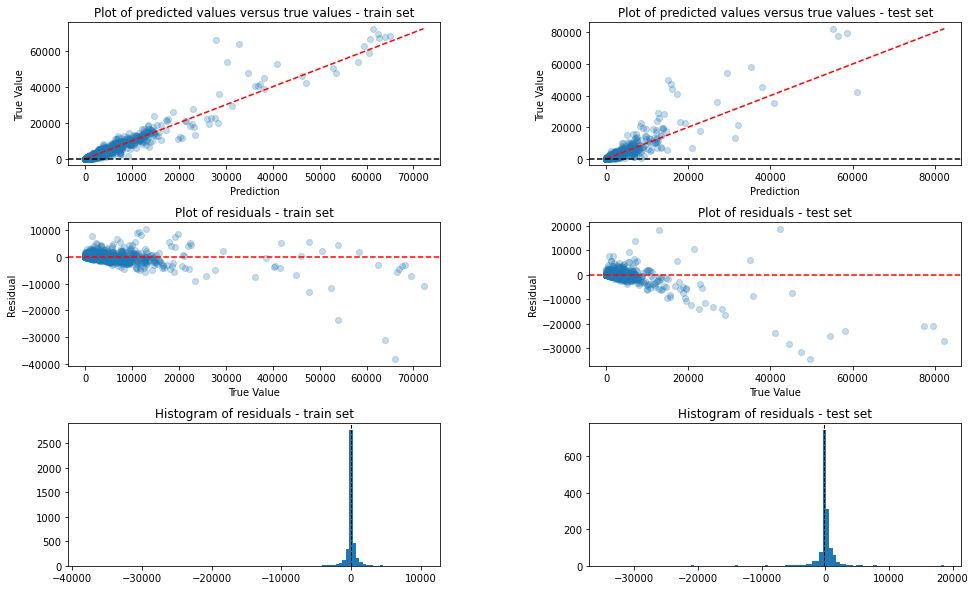

RMSE train: 1261.329949529376
DPA  train: 76.68781707739673
BIAS train: -0.11006046528200318

RMSE test:  2749.994553358526
DPA  test: 59.000447792767275
BIAS test: -6.495381144694731


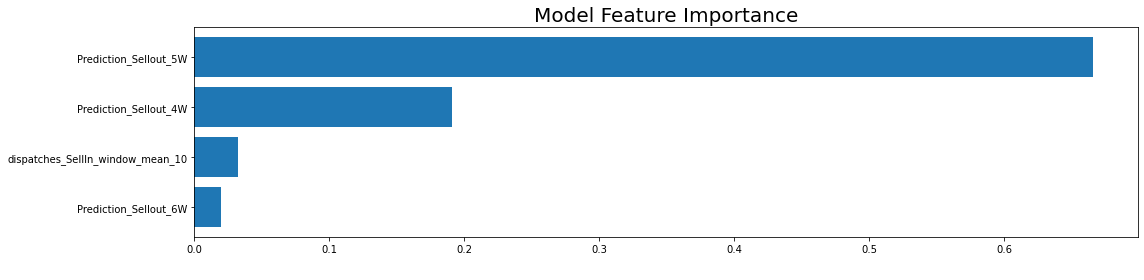

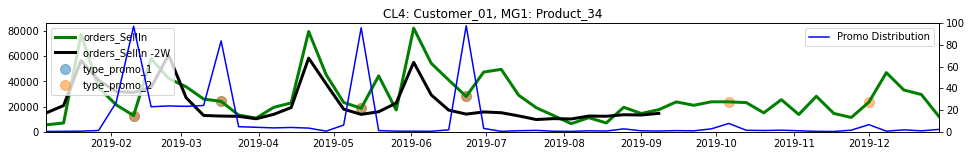

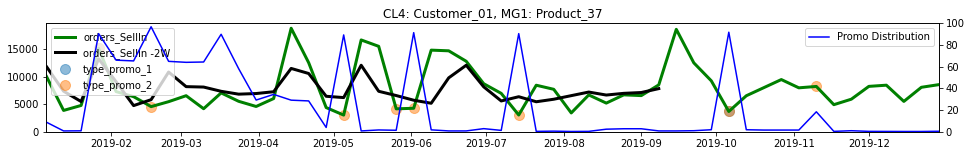

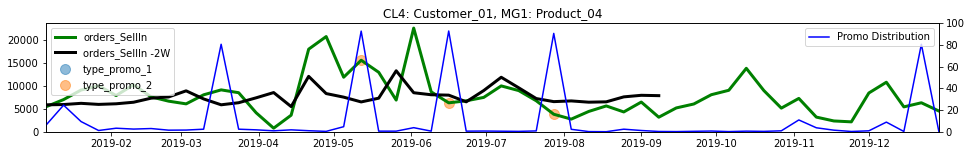

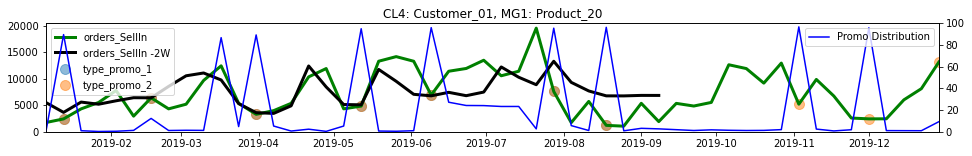

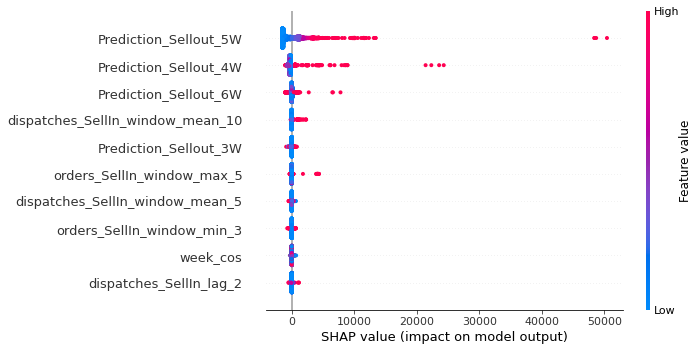

None

Finished iterating in: 35 seconds


|---------------------------	orders_SellIn_3W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['orders_SellIn_3W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'Prediction_Sellout_4W', 'Prediction_Sellout_5W', 'Prediction_Sellout_6W', 'Prediction_Sellout_7W', 'orders_SellIn', 'orders_SellIn_lag_1', 'orders_SellIn_lag_2', 'orders_SellIn_lag_3', 'orders_SellIn_lag_4', 'orders_SellIn_lag_5', 'dispatches_SellIn', 'dispatches_SellIn_lag_1', 'dispatches_SellIn_lag_2', 'dispatches_SellIn_lag_3', 'dispatches_SellIn_lag_4', 'dispatches_SellIn_lag_5', 'orders_SellIn_window_std_2', 'orders_SellIn_window_std_3', 'orders_SellIn_window_std_4', 'orders_SellIn_window_std_5', 'orders_SellIn_window_min_2', 'orders_SellIn_window_min_3', 'orders_SellIn_window_min_4', 'orders_SellIn_window_min_5', 'orders_SellIn_window_max_2', 

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   

            Prediction_Sellout_4W  Prediction_Sellout_5W  \
PERIOD_TAG                                                 
2016-10-09             123.632893             112.294252   
2016-10-16             114.581641             106.886399   
2016-10-23             104.601230             103.804024   
2016-10-30             118.972864             111.830400   
2016-11-06              78.789461             100.102375   
...                           ...                    ...   
2018-11-11            1684.606057            1815.667981   
2018-11-18            1739.343621            1814.427083   
2018-11-25            2197.994364            4402.439317   
2018-12-02            4766.370994            2308.126712   
2018-12-09            2326.266063            2143.413008   

            Prediction_Sellout_6W  Prediction_Sellout_7W  orders_SellIn  \
PERIOD_TAG                                                                
2016-10-09             111.734901             111.964847            164   
2016-10-16             107.653771             104.999319            131   
2016-10-23             104.347765             103.936434             59   
2016-10-30             107.666545             105.354632            205   
2016-11-06             100.520099             100.547412            187   
...                           ...                    ...            ...   
2018-11-11            1841.848431            3802.800551            950   
2018-11-18            4524.068715            2117.943045            993   
2018-11-25            2297.195904            2431.508333            345   
2018-12-02            2399.756887            2208.075905            864   
2018-12-09            1983.603607            2083.498947           1900   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2016-10-09                  0.0                260.0  ...   
2016-10-16                164.0                  0.0  ...   
2016-10-23                131.0                164.0  ...   
2016-10-30                 59.0                131.0  ...   
2016-11-06                205.0                 59.0  ...   
...                         ...                  ...  ...   
2018-11-11               3067.0               2289.0  ...   
2018-11-18                950.0               3067.0  ...   
2018-11-25                993.0                950.0  ...   
2018-12-02                345.0                993.0  ...   
2018-12-09                864.0                345.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2016-10-09                      107.472089                       93.122500   
2016-10-16                      107.472089                       93.138070   
2016-10-23                       73.505102                       99.672965   
2016-10-30                       61.759615                       82.259954   
2016-11-06                       65.714027                       57.508260   
...                                    ...                             ...   
2018-11-11                      889.844322 

PERIOD_TAG
2016-10-09     205.0
2016-10-16     187.0
2016-10-23       1.0
2016-10-30     154.0
2016-11-06     129.0
               ...  
2018-11-11     864.0
2018-11-18    1900.0
2018-11-25    2894.0
2018-12-02     734.0
2018-12-09    1900.0
Name: orders_SellIn_3W, Length: 4180, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   
2018-12-30 -0.118273  0.992981                          1   
2019-01-06  0.118273  0.992981                          1   
2019-01-13  0.234886  0.972023                          1   
...              ...       ...                        ...   
2019-07-28 -0.403123 -0.915146                          1   
2019-08-04 -0.508531 -0.861044                          1   
2019-08-11 -0.606800 -0.794854                          1   
2019-08-18 -0.696551 -0.717507                          1   
2019-08-25 -0.776524 -0.630088                          1   

            Prediction_Sellout_4W  Prediction_Sellout_5W  \
PERIOD_TAG                                                 
2018-12-16             131.554790             134.826709   
2018-12-23             131.554790             137.858626   
2018-12-30             136.770408             143.988202   
2019-01-06             136.770408             142.761235   
2019-01-13             136.770408             142.945351   
...                           ...                    ...   
2019-07-28            1964.620058            1856.147181   
2019-08-04            2044.114409            1855.754151   
2019-08-11            1633.930317            1868.168561   
2019-08-18            1580.811806            1780.505329   
2019-08-25            1564.433839            1641.807948   

            Prediction_Sellout_6W  Prediction_Sellout_7W  orders_SellIn  \
PERIOD_TAG                                                                
2018-12-16             144.000862             149.029636              0   
2018-12-23             144.165620             152.592244             59   
2018-12-30             146.166096             156.817470            403   
2019-01-06             145.631395             154.267580              2   
2019-01-13             145.631395             154.267580            116   
...                           ...                    ...            ...   
2019-07-28            1837.342689            1890.711133           2937   
2019-08-04            1956.641603            1869.185703           2160   
2019-08-11            1779.816779            1674.560661           1864   
2019-08-18            1722.640491            1705.254876           1209   
2019-08-25            1694.102078            1707.732827            738   

            orders_SellIn_lag_1  orders_SellIn_lag_2  ...  \
PERIOD_TAG                                            ...   
2018-12-16                 59.0                288.0  ...   
2018-12-23                  0.0                 59.0  ...   
2018-12-30                 59.0                  0.0  ...   
2019-01-06                403.0                 59.0  ...   
2019-01-13                  2.0                403.0  ...   
...                         ...                  ...  ...   
2019-07-28               3247.0               1561.0  ...   
2019-08-04               2937.0               3247.0  ...   
2019-08-11               2160.0               2937.0  ...   
2019-08-18               1864.0               2160.0  ...   
2019-08-25               1209.0               1864.0  ...   

            dispatches_SellIn_window_std_4  dispatches_SellIn_window_std_5  \
PERIOD_TAG                                                                   
2018-12-16                      136.600085                      148.508586   
2018-12-23                      127.406175                      118.971845   
2018-12-30                      183.948136                      174.226003   
2019-01-06                      193.278728                      169.314205   
2019-01-13                      178.185297                      167.384288   
...                                    ...                             ...   
2019-07-28                     1028.080858 

PERIOD_TAG
2018-12-16       2.0
2018-12-23     116.0
2018-12-30     231.0
2019-01-06      57.0
2019-01-13     173.0
               ...  
2019-07-28    1209.0
2019-08-04     738.0
2019-08-11    1040.0
2019-08-18    1086.0
2019-08-25    1946.0
Name: orders_SellIn_3W, Length: 1517, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=7,
                                       n_jobs=3, random_state=123))])

The best score: 
-16233956.03161622

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 7, 'regressor__n_estimators': 100}

Evaluation charts


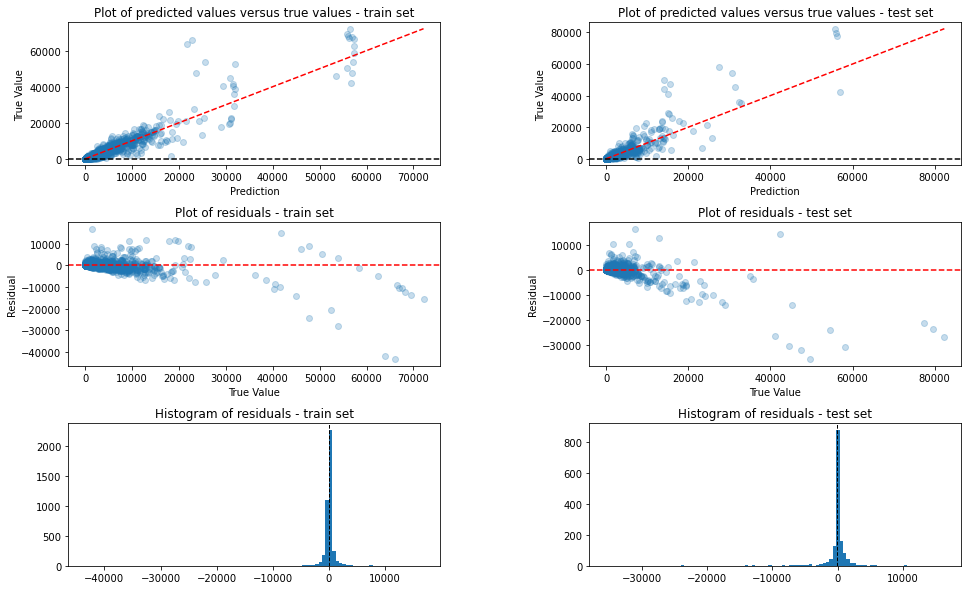

RMSE train: 1696.9499665813753
DPA  train: 71.88597642515336
BIAS train: 0.062294670133952006

RMSE test:  2781.901172432071
DPA  test: 58.14547295073016
BIAS test: -6.677876485032354


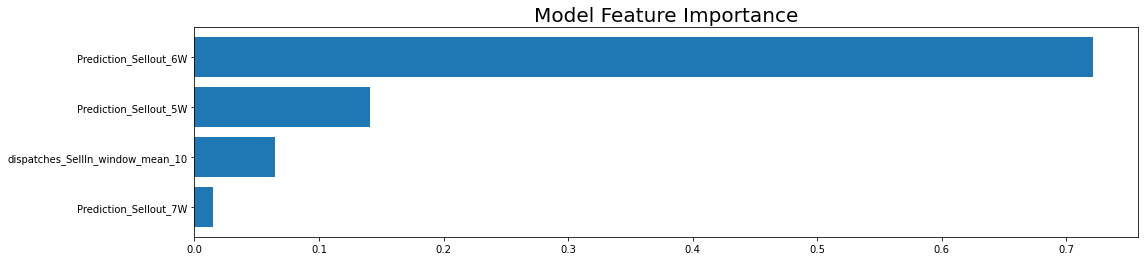

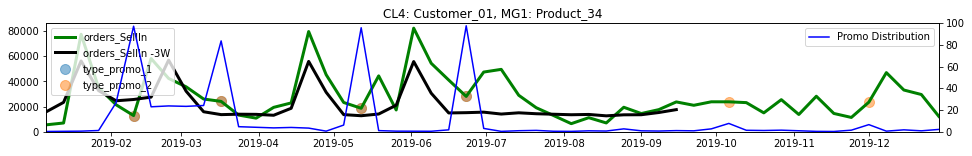

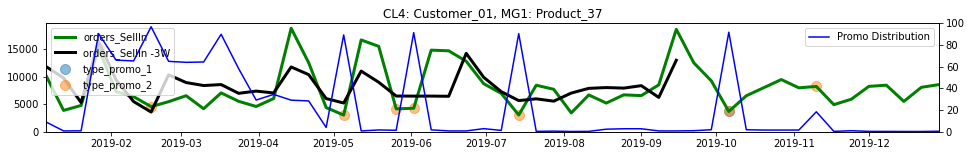

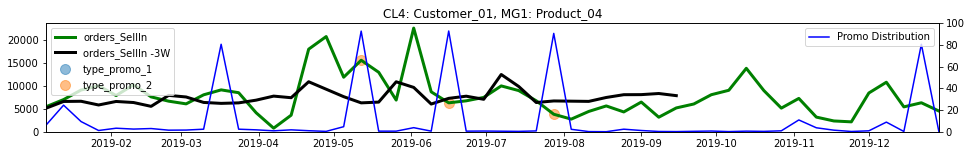

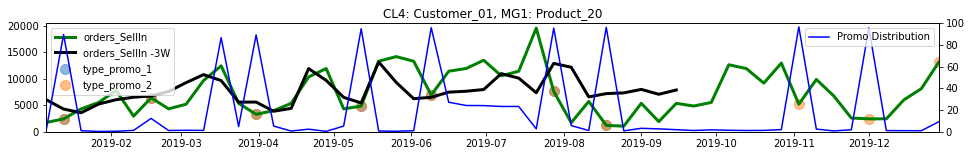

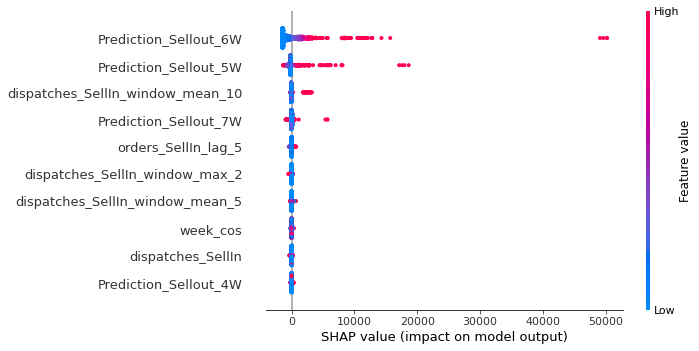

None

Finished iterating in: 39 seconds


|---------------------------	orders_SellIn_4W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['orders_SellIn_4W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'Prediction_Sellout_5W', 'Prediction_Sellout_6W', 'Prediction_Sellout_7W', 'Prediction_Sellout_8W', 'dispatches_SellIn_window_mean_5', 'dispatches_SellIn_window_mean_10', 'orders_SellIn_window_std_10', 'orders_SellIn_window_min_10', 'orders_SellIn_window_max_10', 'dispatches_SellIn_window_std_10', 'dispatches_SellIn_window_min_10', 'dispatches_SellIn_window_max_10', 'difference_window_sum_10']
Number: 19
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
     

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-11-18 -0.737833  0.674983                          1   
2018-10-28 -0.926690  0.375828                          1   
2018-11-04 -0.875735  0.482792                          1   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   

            Prediction_Sellout_7W  Prediction_Sellout_8W  \
PERIOD_TAG                                                 
2016-10-09             111.964847             109.798010   
2016-10-16             104.999319             106.747543   
2016-10-23             103.936434             103.225264   
2016-10-30             105.354632             108.155453   
2016-11-06             100.547412              98.965274   
...                           ...                    ...   
2018-11-18             234.897914             240.388121   
2018-10-28            1417.820267            1644.975313   
2018-11-04            1582.567100            3784.198780   
2018-11-11            3802.800551            2104.474222   
2018-11-18            2117.943045            2211.375504   

            Prediction_Sellout_9W  Prediction_Sellout_10W  \
PERIOD_TAG                                                  
2016-10-09             104.140538              103.834914   
2016-10-16             105.347154              103.705791   
2016-10-23             102.680039              101.497830   
2016-10-30             108.555693              106.172242   
2016-11-06              98.333642              107.399519   
...                           ...                     ...   
2018-11-18             236.715594              235.288647   
2018-10-28            3734.294504             1691.928852   
2018-11-04            1812.281238             1899.391651   
2018-11-11            2169.231402             2133.475502   
2018-11-18            2121.233781             2221.839929   

            dispatches_SellIn_window_mean_5  dispatches_SellIn_window_mean_10  \
PERIOD_TAG                                                                      
2016-10-09                            137.4                             106.9   
2016-10-16                            137.2                             107.0   
2016-10-23                            122.8                             112.5   
2016-10-30                            111.8                             120.0   
2016-11-06                            149.2                             132.6   
...                                     ...                               ...   
2018-11-18                            246.2                             217.8   
2018-10-28                           2461.2                            2638.8   
2018-11-04                           2307.4                            2595.6   
2018-11-11                           1783.8                            2474.6   
2018-11-18                           1814.0                            2349.3   

            orders_SellIn_window_std_10  orders_SellIn_window_min_10  \
PERIOD_TAG                                                             
2016-10-09                    78.377222                          0.0   
2016-10-16                    78.410317                          0.0   
2016-10-23                    72.203724                          0.0   
2016-10-30                    77.883745                          0.0   
2016-11-06                    77.451132                          0.0   
...                                 ...                          ...   
2018-11-18   

PERIOD_TAG
2016-10-09     154.0
2016-10-16     129.0
2016-10-23     203.0
2016-10-30     167.0
2016-11-06       2.0
               ...  
2018-11-18     207.0
2018-10-28    1900.0
2018-11-04    2894.0
2018-11-11     734.0
2018-11-18    1900.0
Name: orders_SellIn_6W, Length: 4057, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-11-25 -0.652822  0.757511                          1   
2018-12-02 -0.558647  0.829406                          1   
2018-12-09 -0.456629  0.889657                          1   
2018-12-16 -0.348202  0.937420                          1   
2018-12-23 -0.234886  0.972023                          1   
...              ...       ...                        ...   
2019-07-28 -0.403123 -0.915146                          1   
2019-08-04 -0.508531 -0.861044                          1   
2019-08-11 -0.606800 -0.794854                          1   
2019-08-18 -0.696551 -0.717507                          1   
2019-08-25 -0.776524 -0.630088                          1   

            Prediction_Sellout_7W  Prediction_Sellout_8W  \
PERIOD_TAG                                                 
2018-11-25             114.230591             116.758110   
2018-12-02             117.132173             116.993408   
2018-12-09             117.132173             116.993408   
2018-12-16             149.029636             144.891160   
2018-12-23             152.592244             146.837518   
...                           ...                    ...   
2019-07-28            1890.711133            1788.581456   
2019-08-04            1869.185703            1823.497592   
2019-08-11            1674.560661            1693.589322   
2019-08-18            1705.254876            1692.140117   
2019-08-25            1707.732827            1661.801455   

            Prediction_Sellout_9W  Prediction_Sellout_10W  \
PERIOD_TAG                                                  
2018-11-25             123.325018              114.708247   
2018-12-02             124.397446              118.847534   
2018-12-09             124.397446              118.847534   
2018-12-16             140.415154              123.054592   
2018-12-23             140.982779              128.721190   
...                           ...                     ...   
2019-07-28            1817.009542             1835.896727   
2019-08-04            1884.814080             1993.408766   
2019-08-11            1676.171062             1748.244053   
2019-08-18            1687.556898             1709.056659   
2019-08-25            1617.974470             1610.422474   

            dispatches_SellIn_window_mean_5  dispatches_SellIn_window_mean_10  \
PERIOD_TAG                                                                      
2018-11-25                            128.4                             122.0   
2018-12-02                            185.0                             133.5   
2018-12-09                            185.2                             133.6   
2018-12-16                            127.4                             121.9   
2018-12-23                             81.6                             116.3   
...                                     ...                               ...   
2019-07-28                           1941.6                            1849.3   
2019-08-04                           2131.4                            2000.4   
2019-08-11                           2304.8                            1938.2   
2019-08-18                           2234.4                            1929.5   
2019-08-25                           1732.6                            1819.2   

            orders_SellIn_window_std_10  orders_SellIn_window_min_10  \
PERIOD_TAG                                                             
2018-11-25                   102.442396                          2.0   
2018-12-02                   114.543781                          2.0   
2018-12-09                   114.470957                          2.0   
2018-12-16                   122.082349                          0.0   
2018-12-23                   123.707585                          0.0   
...                                 ...                          ...   
2019-07-28   

PERIOD_TAG
2018-11-25       2.0
2018-12-02     116.0
2018-12-09     231.0
2018-12-16      57.0
2018-12-23     173.0
               ...  
2019-07-28    1086.0
2019-08-04    1946.0
2019-08-11    1863.0
2019-08-18    1946.0
2019-08-25    1476.0
Name: orders_SellIn_6W, Length: 1640, dtype: float64

--------------------------------------------------------

Evaluation charts


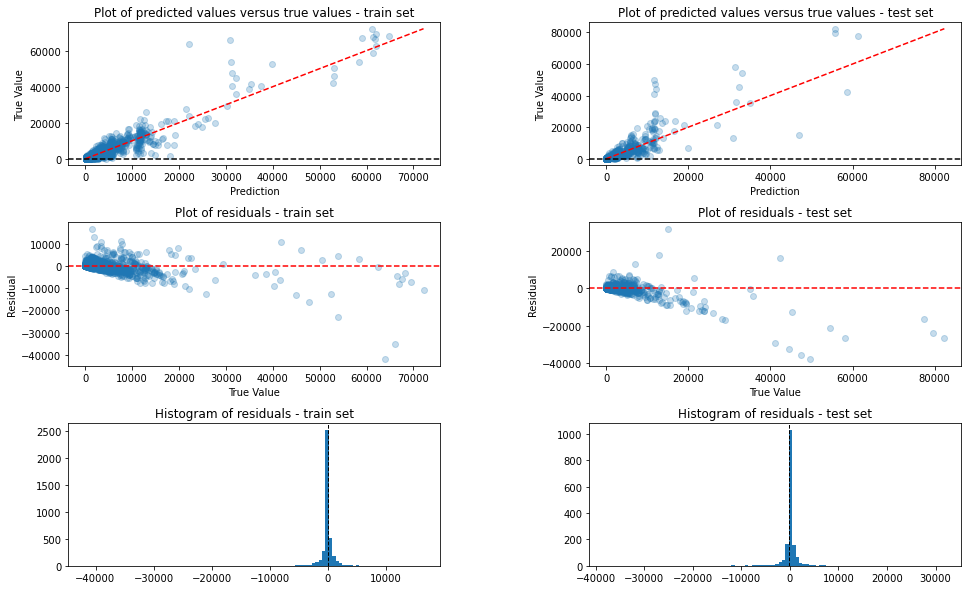

RMSE train: 1659.0698017955488
DPA  train: 66.04108798386665
BIAS train: -0.26833504374011913

RMSE test:  2926.7715587612656
DPA  test: 57.127955046725646
BIAS test: -7.747978426665683


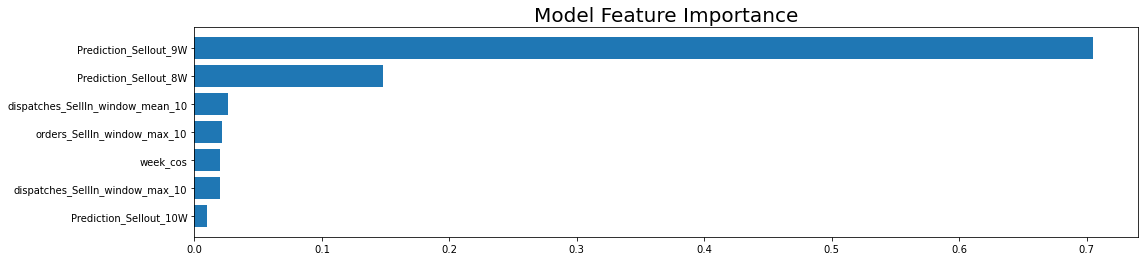

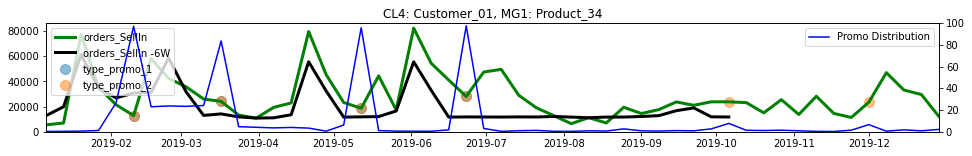

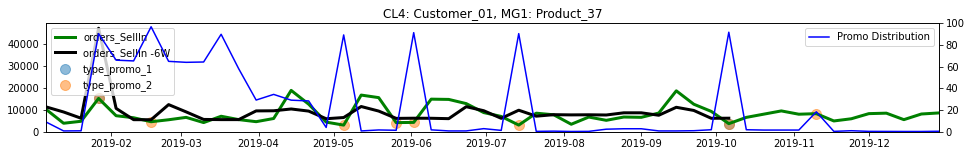

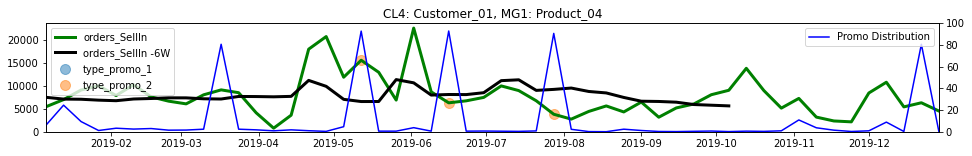

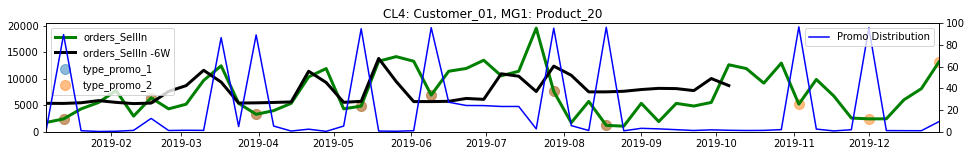

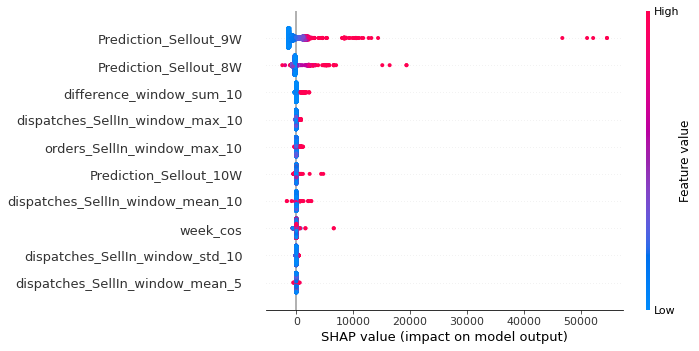

None

Finished iterating in: 8 seconds


|---------------------------	orders_SellIn_7W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['orders_SellIn_7W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'Prediction_Sellout_8W', 'Prediction_Sellout_9W', 'Prediction_Sellout_10W', 'Prediction_Sellout_11W', 'dispatches_SellIn_window_mean_5', 'dispatches_SellIn_window_mean_10', 'orders_SellIn_window_std_10', 'orders_SellIn_window_min_10', 'orders_SellIn_window_max_10', 'dispatches_SellIn_window_std_10', 'dispatches_SellIn_window_min_10', 'dispatches_SellIn_window_max_10', 'difference_window_sum_10']
Number: 19
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Finished iterating in: 5 seconds


|---------------------------	orders_SellIn_8W	---------------------------|
-----

week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2016-10-09 -0.999561  0.029633                          1   
2016-10-16 -0.989040  0.147647                          1   
2016-10-23 -0.964636  0.263587                          1   
2016-10-30 -0.926690  0.375828                          1   
2016-11-06 -0.875735  0.482792                          1   
...              ...       ...                        ...   
2018-09-23 -0.978556 -0.205979                          1   
2018-09-30 -0.996050 -0.088796                          1   
2018-10-07 -0.999561  0.029633                          1   
2018-10-14 -0.989040  0.147647                          1   
2018-10-21 -0.964636  0.263587                          1   

            Prediction_Sellout_11W  Prediction_Sellout_12W  \
PERIOD_TAG                                                   
2016-10-09              101.418635               99.326715   
2016-10-16              101.150075               99.636858   
2016-10-23               99.287465              101.789996   
2016-10-30              118.749559              107.844114   
2016-11-06               96.671764              101.992530   
...                            ...                     ...   
2018-09-23              264.487384              272.049006   
2018-09-30              265.060717              261.627190   
2018-10-07              276.087246              319.047110   
2018-10-14              287.458502              334.094252   
2018-10-21              296.210878              337.933661   

            Prediction_Sellout_13W  Prediction_Sellout_14W  \
PERIOD_TAG                                                   
2016-10-09               99.071520              111.792077   
2016-10-16              103.182826               92.397734   
2016-10-23               96.093416              103.224402   
2016-10-30              113.470932              100.711178   
2016-11-06               90.697028               89.214939   
...                            ...                     ...   
2018-09-23              263.818860              279.429794   
2018-09-30              283.125834              278.644325   
2018-10-07              334.676496              333.334705   
2018-10-14              337.105680              346.789548   
2018-10-21              342.702551              324.463923   

            dispatches_SellIn_window_mean_5  dispatches_SellIn_window_mean_10  \
PERIOD_TAG                                                                      
2016-10-09                            137.4                             106.9   
2016-10-16                            137.2                             107.0   
2016-10-23                            122.8                             112.5   
2016-10-30                            111.8                             120.0   
2016-11-06                            149.2                             132.6   
...                                     ...                               ...   
2018-09-23                            219.0                             133.5   
2018-09-30                            214.4                             130.1   
2018-10-07                            200.8                             142.9   
2018-10-14                            189.4                             152.1   
2018-10-21                            138.2                             172.8   

            orders_SellIn_window_std_10  orders_SellIn_window_min_10  \
PERIOD_TAG                                                             
2016-10-09                    78.377222                          0.0   
2016-10-16                    78.410317                          0.0   
2016-10-23                    72.203724                          0.0   
2016-10-30                    77.883745                          0.0   
2016-11-06                    77.451132                          0.0   
...                                 ...       

PERIOD_TAG
2016-10-09      2.0
2016-10-16    262.0
2016-10-23      0.0
2016-10-30    131.0
2016-11-06      0.0
              ...  
2018-09-23     34.0
2018-09-30     57.0
2018-10-07     23.0
2018-10-14     34.0
2018-10-21    207.0
Name: orders_SellIn_10W, Length: 3893, dtype: float64

--------------------------------------------------------
Creating a test set


week_sin  week_cos  customer_name_Customer_01  \
PERIOD_TAG                                                  
2018-10-28 -0.926690  0.375828                          1   
2018-11-04 -0.875735  0.482792                          1   
2018-11-11 -0.812487  0.582979                          1   
2018-11-18 -0.737833  0.674983                          1   
2018-11-25 -0.652822  0.757511                          1   
...              ...       ...                        ...   
2019-07-28 -0.403123 -0.915146                          1   
2019-08-04 -0.508531 -0.861044                          1   
2019-08-11 -0.606800 -0.794854                          1   
2019-08-18 -0.696551 -0.717507                          1   
2019-08-25 -0.776524 -0.630088                          1   

            Prediction_Sellout_11W  Prediction_Sellout_12W  \
PERIOD_TAG                                                   
2018-10-28              124.567463              130.621951   
2018-11-04              125.471617              132.460180   
2018-11-11              124.206026              122.385117   
2018-11-18              122.921373              121.827805   
2018-11-25              122.921373              121.827805   
...                            ...                     ...   
2019-07-28             1838.947409             1745.462339   
2019-08-04             1885.803938             1788.569559   
2019-08-11             1714.281780             1685.307542   
2019-08-18             1676.548015             1588.956921   
2019-08-25             1598.757497             1564.708158   

            Prediction_Sellout_13W  Prediction_Sellout_14W  \
PERIOD_TAG                                                   
2018-10-28              129.547690              119.085494   
2018-11-04              134.105408              129.286186   
2018-11-11              127.524339              114.229849   
2018-11-18              127.524339              113.720063   
2018-11-25              127.524339              113.720063   
...                            ...                     ...   
2019-07-28             1811.853262             1848.682799   
2019-08-04             1859.592433             1946.780001   
2019-08-11             1581.472921             1659.576463   
2019-08-18             1598.802205             1610.931151   
2019-08-25             1604.890043             1614.657411   

            dispatches_SellIn_window_mean_5  dispatches_SellIn_window_mean_10  \
PERIOD_TAG                                                                      
2018-10-28                             82.0                             110.2   
2018-11-04                             82.0                             104.5   
2018-11-11                            116.4                             121.8   
2018-11-18                            151.0                             121.8   
2018-11-25                            128.4                             122.0   
...                                     ...                               ...   
2019-07-28                           1941.6                            1849.3   
2019-08-04                           2131.4                            2000.4   
2019-08-11                           2304.8                            1938.2   
2019-08-18                           2234.4                            1929.5   
2019-08-25                           1732.6                            1819.2   

            orders_SellIn_window_std_10  orders_SellIn_window_min_10  \
PERIOD_TAG                                                             
2018-10-28                    82.759088                          0.0   
2018-11-04                    84.339591                          0.0   
2018-11-11                   102.704322                          0.0   
2018-11-18                   102.704322                          0.0   
2018-11-25                   102.442396                          2.0   
...                                 ...       

PERIOD_TAG
2018-10-28       2.0
2018-11-04     116.0
2018-11-11     231.0
2018-11-18      57.0
2018-11-25     173.0
               ...  
2019-07-28    1476.0
2019-08-04    2377.0
2019-08-11    1391.0
2019-08-18    2289.0
2019-08-25    2338.0
Name: orders_SellIn_10W, Length: 1804, dtype: float64

--------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=7,
                                       n_jobs=3, random_state=123))])

The best score: 
-16280435.482679512

The best parameters: 
{'regressor__criterion': 'mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 7, 'regressor__n_estimators': 100}

Evaluation charts


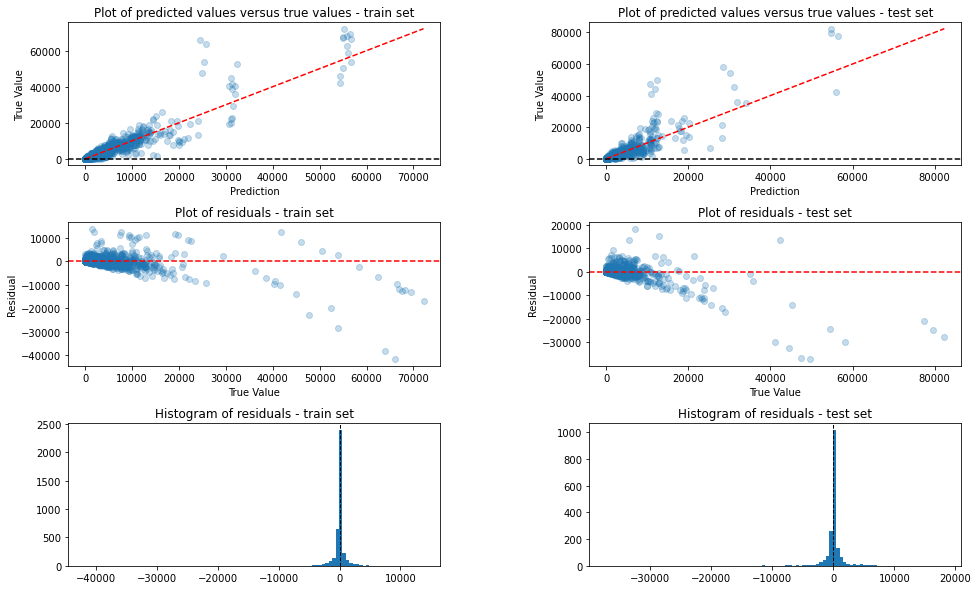

RMSE train: 1762.3127282032292
DPA  train: 69.58593186938361
BIAS train: -0.20713689439409486

RMSE test:  2794.8833544995578
DPA  test: 58.27722986763365
BIAS test: -6.349955477267592


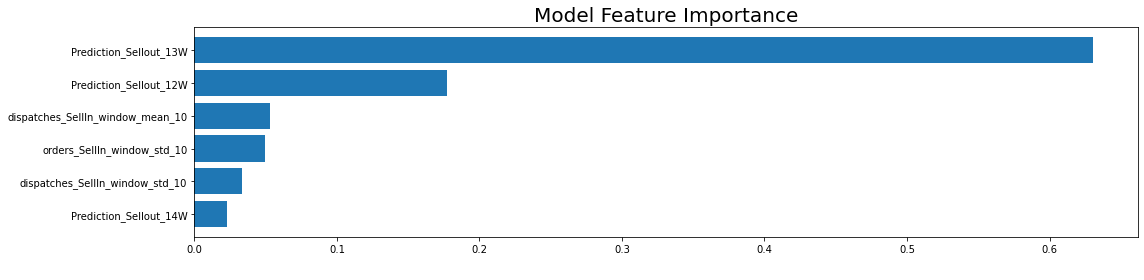

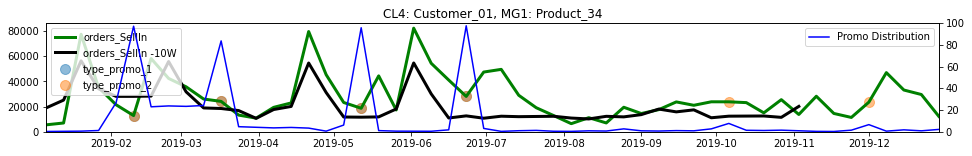

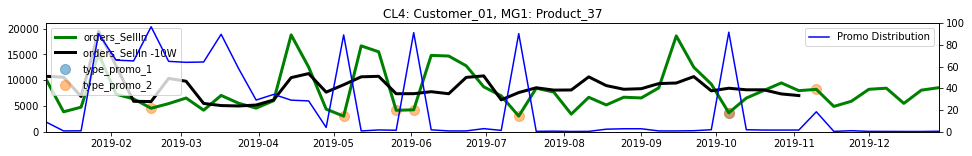

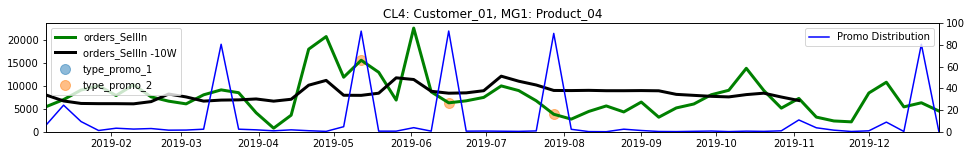

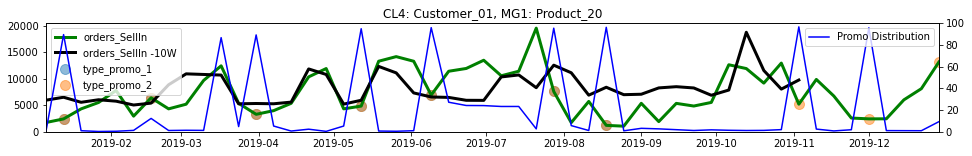

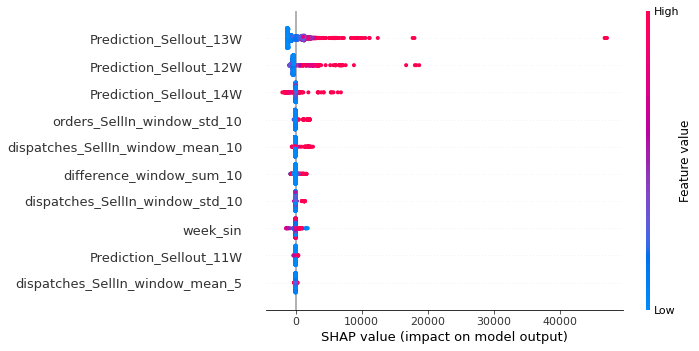

None

Finished iterating in: 18 seconds


|---------------------------	orders_SellIn_11W	---------------------------|
--------------------------------------------------------
Creating a training set
Categoric features:
1
Selected_variables:
['orders_SellIn_11W', 'customer_name', 'product_group', 'week_sin', 'week_cos', 'customer_name_Customer_01', 'Prediction_Sellout_12W', 'Prediction_Sellout_13W', 'Prediction_Sellout_14W', 'Prediction_Sellout_15W', 'dispatches_SellIn_window_mean_5', 'dispatches_SellIn_window_mean_10', 'orders_SellIn_window_std_10', 'orders_SellIn_window_min_10', 'orders_SellIn_window_max_10', 'dispatches_SellIn_window_std_10', 'dispatches_SellIn_window_min_10', 'dispatches_SellIn_window_max_10', 'difference_window_sum_10']
Number: 19
--------------------------------------------------------
Creating a test set
--------------------------------------------------------
Finished iterating in: 5 seconds


|---------------------------	orders_SellIn_12W	---------------------------|

In [17]:
dataset_copied = dataset.copy()

for horizon_prediction in target_columns:
    start_time = time.time()
    print(f'|---------------------------\t{horizon_prediction}\t---------------------------|')
    if horizon_prediction[:7] == 'Sellout':
        nr_horizon = int(horizon_prediction[8:-1])
        type_prediction = 'Sellout'
        target_name = 'Sellout'
    elif horizon_prediction[:13] == 'orders_SellIn':
        nr_horizon = int(horizon_prediction[14:-1])
        type_prediction = 'orders_SellIn'
        target_name = 'orders_SellIn'
    
    ################################################################ Prepare Train Test Sets ######################
    print('--------------------------------------------------------')
    pipeline_preprocessing.set_params(feature_engineering_transformer__nr_horizon=nr_horizon,
                                      feature_engineering_transformer__type_forecast=type_prediction,
                                      feature_engineering_transformer__target=target_name)
    ##### Train ##
    print('Creating a training set')
    train_set = pipeline_preprocessing.fit_transform(
        dataset_copied.loc[dataset_copied['PERIOD_TAG']<first_test_date, :])
    X_train = train_set.drop([horizon_prediction]+['customer_name', 'product_group'], axis = 1).copy()
    y_train = train_set[horizon_prediction].copy()
    if nr_horizon in [1, 2, 3, 6, 10, 25, 52]:
        display(X_train)
        display(y_train)

    print('--------------------------------------------------------')
    ##### Test ##
    print('Creating a test set')
    all_set = pipeline_preprocessing.transform(dataset_copied)
    X = all_set.drop([horizon_prediction]+['customer_name', 'product_group'], axis = 1).copy()
    y = all_set[horizon_prediction].copy()
    
    test_set = all_set.loc[((all_set.index>=(first_test_date - pd.DateOffset(weeks=nr_horizon)))&\
                            (all_set.index<=(end_test_date - pd.DateOffset(weeks=nr_horizon)))), :].copy()
    X_test = test_set.drop([horizon_prediction]+['customer_name', 'product_group'], axis = 1).copy()
    y_test = test_set[horizon_prediction].copy()
    if nr_horizon in [1, 2, 3, 6, 10, 25, 52]:
        display(X_test)
        display(y_test)
    print('--------------------------------------------------------')
    
    
    ################################################################ Hyperparameter Optimization ####################
    random_forest_pipeline = Pipeline(steps=[('regressor', RandomForestRegressor(random_state=123, n_jobs=3))])
    
    param_random_forest = {
        'regressor__max_depth': [5, 10, 15],
        'regressor__min_samples_leaf': [3, 7],
        'regressor__n_estimators': [100],
        'regressor__criterion': ['mse'],
    }
    if nr_horizon in [1, 2, 3, 4, 5, 10, 20, 30, 40, 52]:
        random_forest = GridSearchCV(random_forest_pipeline, param_random_forest, 
                                     cv=TimeSeriesSplit(n_splits=5).split(X_train), n_jobs=3, 
                                     scoring = 'neg_mean_squared_error', verbose=10)
        random_forest.fit(X_train, y_train)
        print("The best estimator: ", random_forest.best_estimator_,
              "\nThe best score: ", random_forest.best_score_,
              "\nThe best parameters: ", random_forest.best_params_, sep="\n")

        random_forest_model = random_forest.best_estimator_
        best_params = random_forest.best_params_
    else:
        random_forest_model = random_forest_pipeline.set_params(**best_params)
        random_forest_model.fit(X_train, y_train)
    
    ################################################################ Add a forecast to a dataset ####################
    all_set[f'Prediction_{type_prediction}_{nr_horizon}W'] = random_forest_model.predict(X)
    all_set.reset_index(inplace=True)
    dataset_copied = pd.merge(dataset_copied,
                              all_set[['PERIOD_TAG', 'customer_name', 'product_group',
                                       f'Prediction_{type_prediction}_{nr_horizon}W']],
                              how='left',
                              on=['PERIOD_TAG', 'customer_name', 'product_group'])
    
    if nr_horizon in [1, 2, 3, 6, 10, 25, 52]:
        print('\nEvaluation charts')
        ### Evaluation check
        model_evaluation(model = random_forest_model,
                         Xtrain = X_train, ytrain = y_train,
                         Xtest  = X_test,  ytest  = y_test)
        ### Plot true vs predictions per biggest CL4/MG1
        plot_true_pred(df=dataset_copied, big_prod=biggest_products, number=4, target=target_name,
                       type_pred=type_prediction, horizon=nr_horizon, scenario=scenario)
        ### model interpretability
        explainer = shap.TreeExplainer(random_forest_model.named_steps["regressor"])
        shap_values = explainer.shap_values(X_test, approximate=True)
        p = shap.summary_plot(shap_values, X_test, max_display=10)
        display(p)
        
    
    ################################################################ Save models !!!!!!!!!!!! ####################
    dump(random_forest_model, 
         f'output/models/model_{horizon_prediction}.pkl',
         compress=True)
    dump(random_forest_model.get_params(), 
         f'output/hyperparameters/hyperparameters_{horizon_prediction}.pkl',
         compress=True)
    dump(pipeline_preprocessing, 
         f'output/preprocessing/preprocessing_{horizon_prediction}.pkl',
         compress=True)
    
    
    elapsed_time = time.time() - start_time
    print("Finished iterating in: " + str(int(elapsed_time))  + " seconds")
    print('\n')

# 6. Make the Forecast

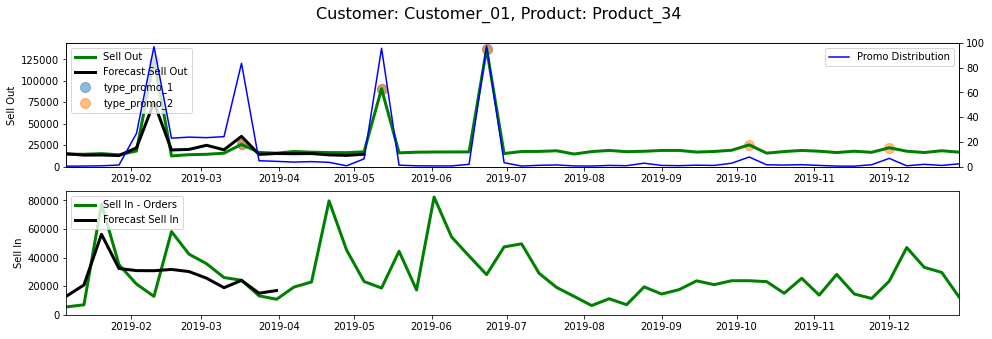

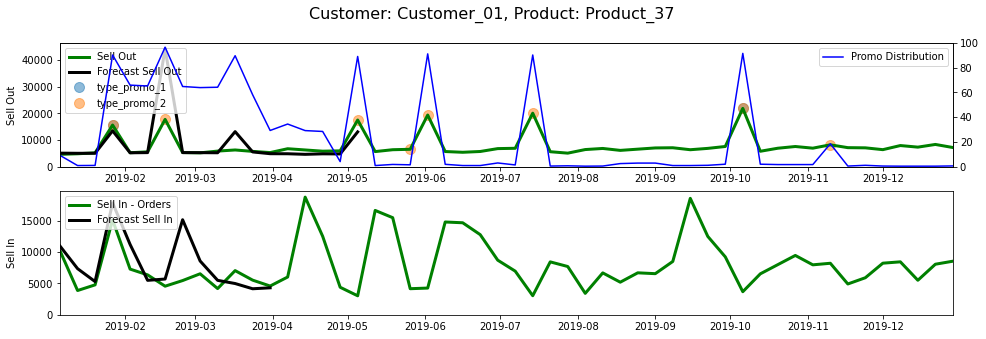

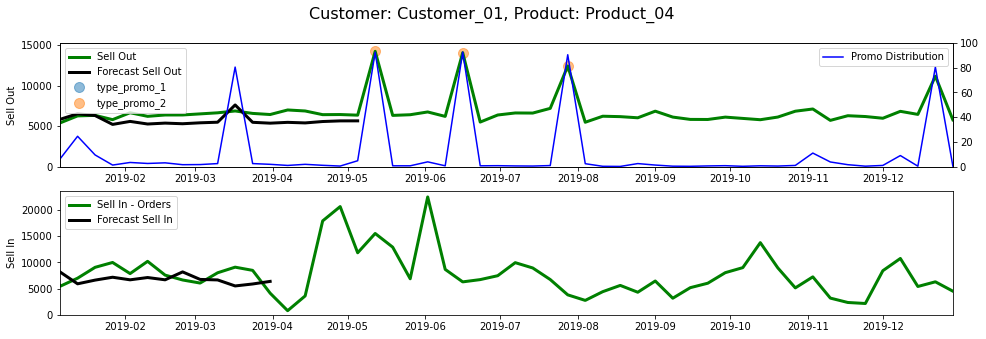

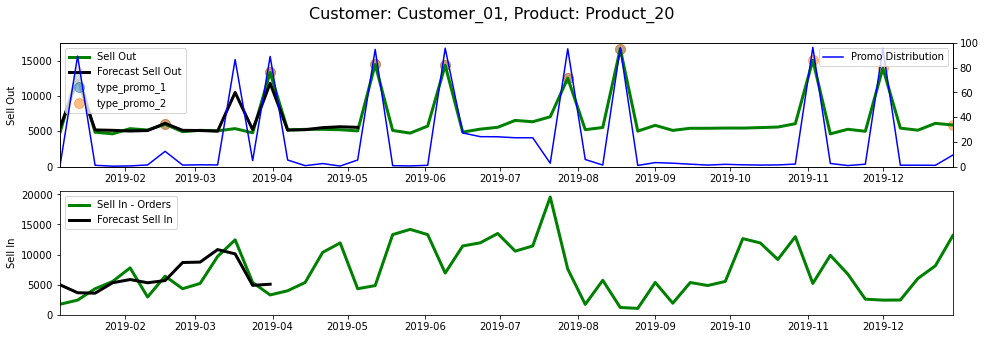

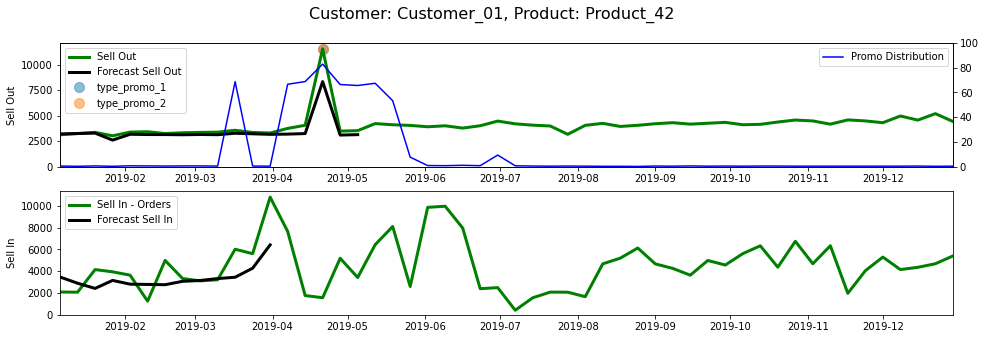

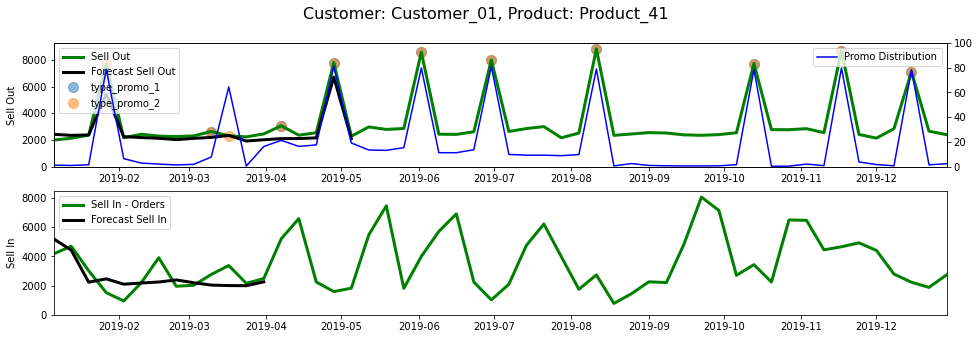

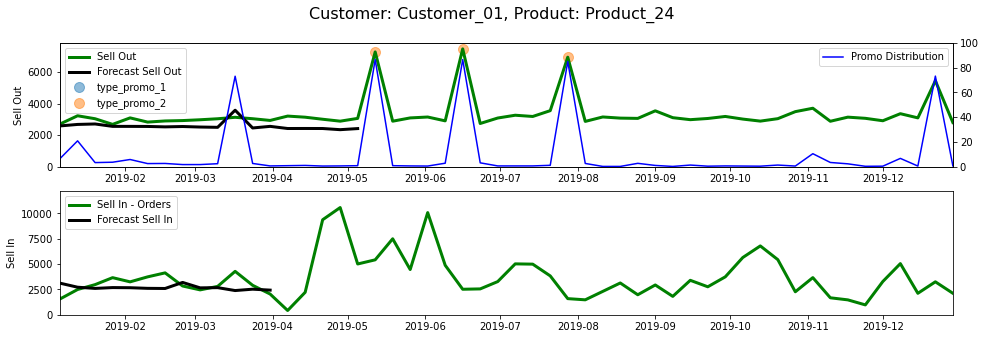

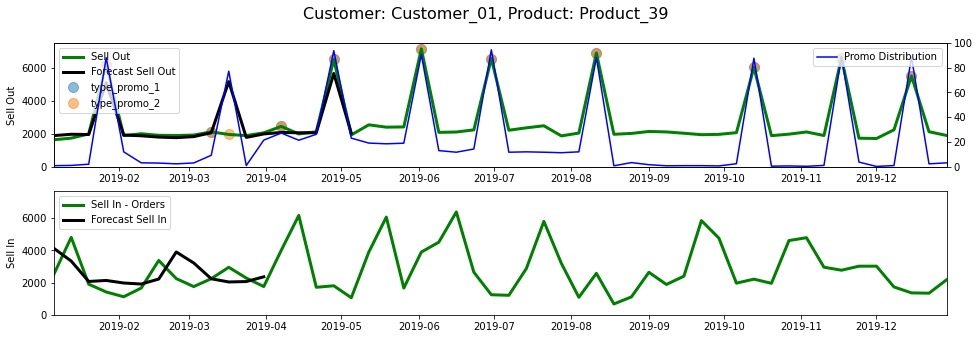

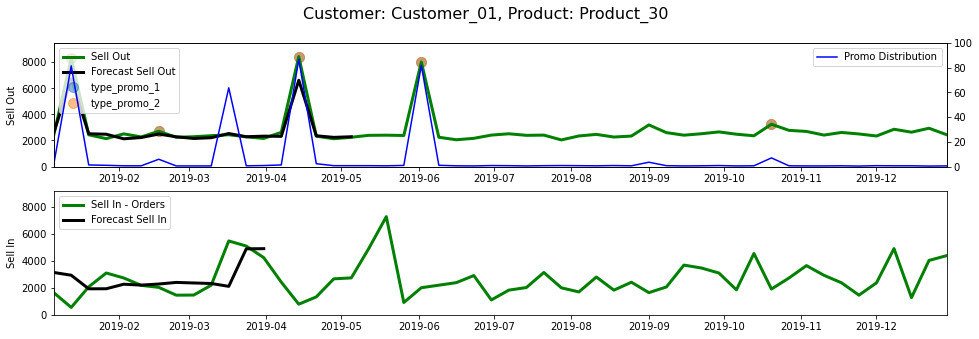

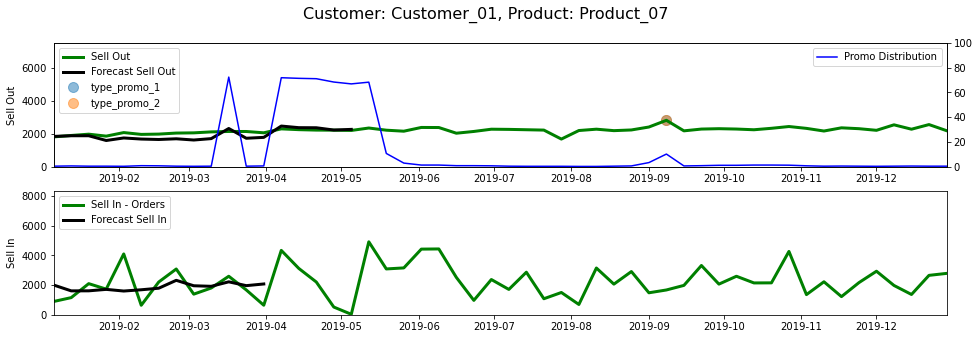

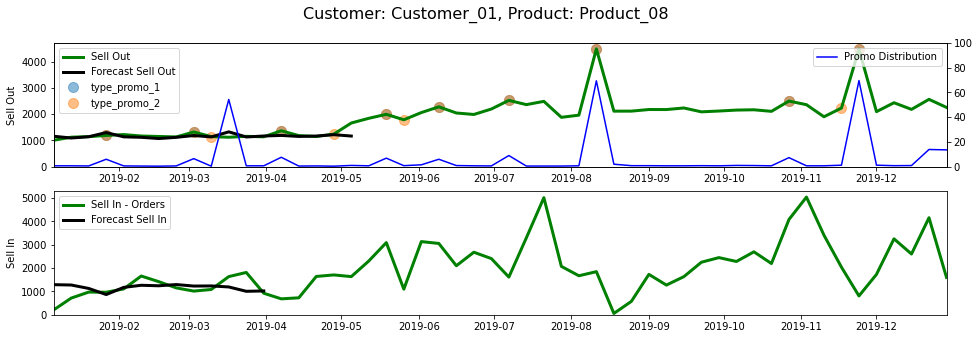

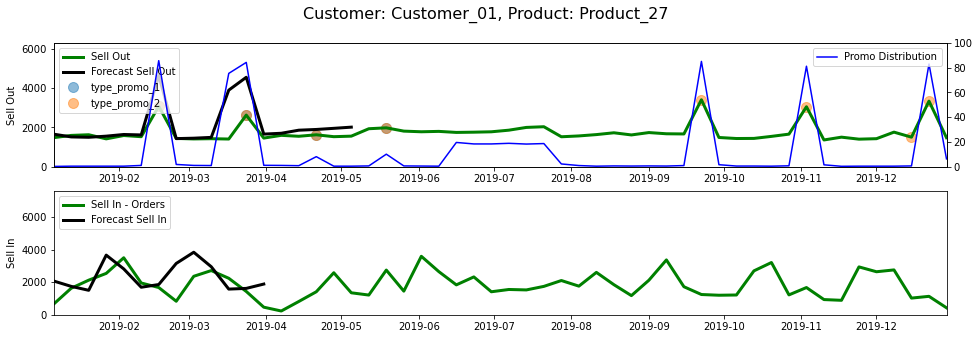

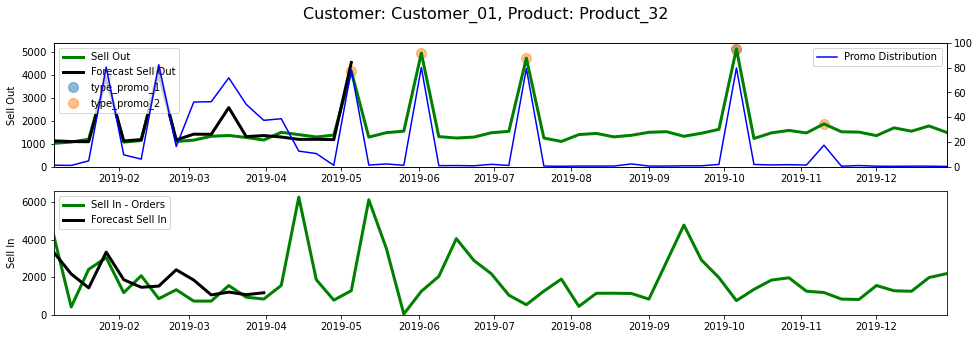

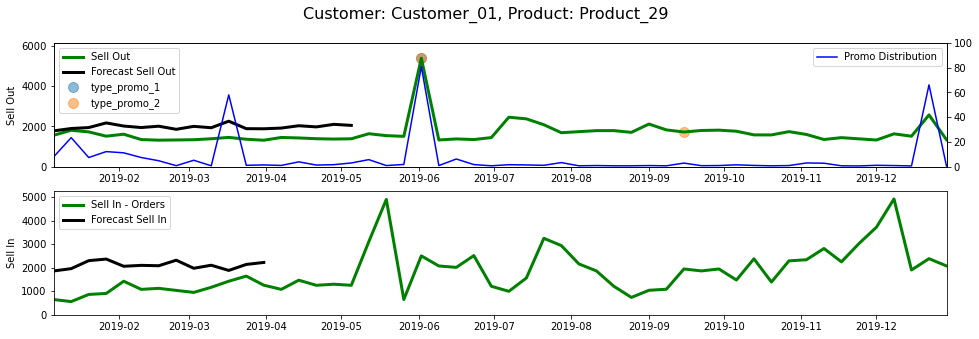

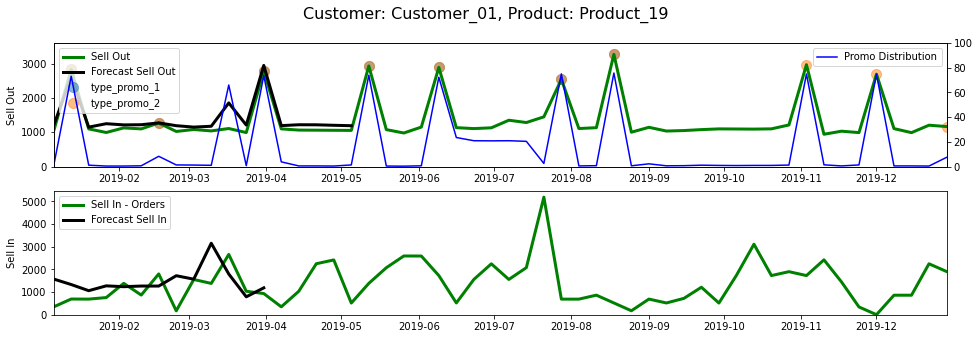

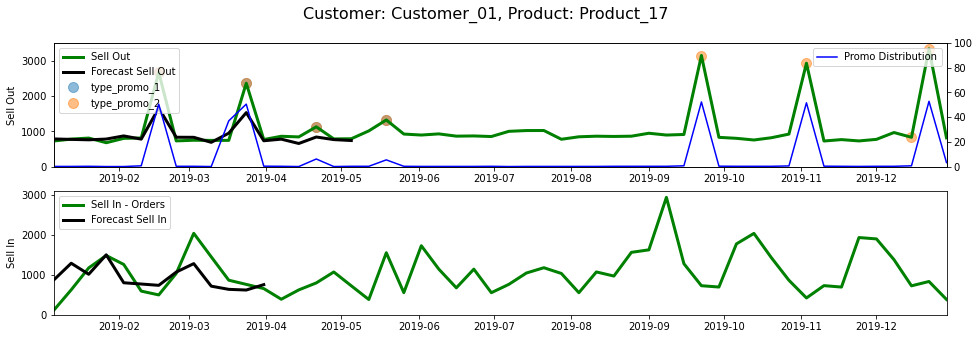

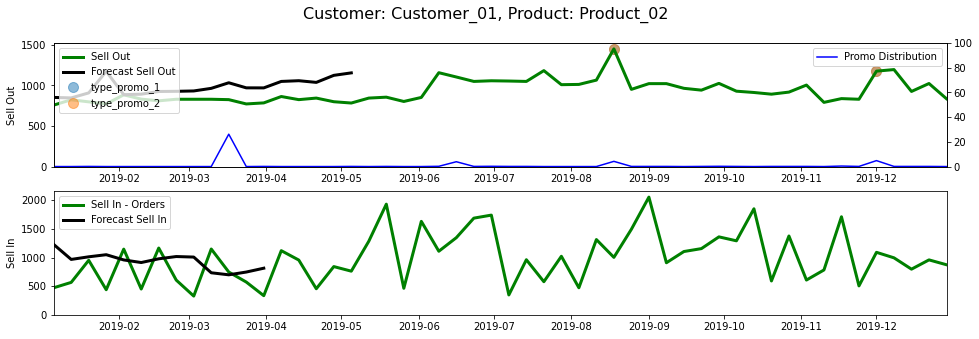

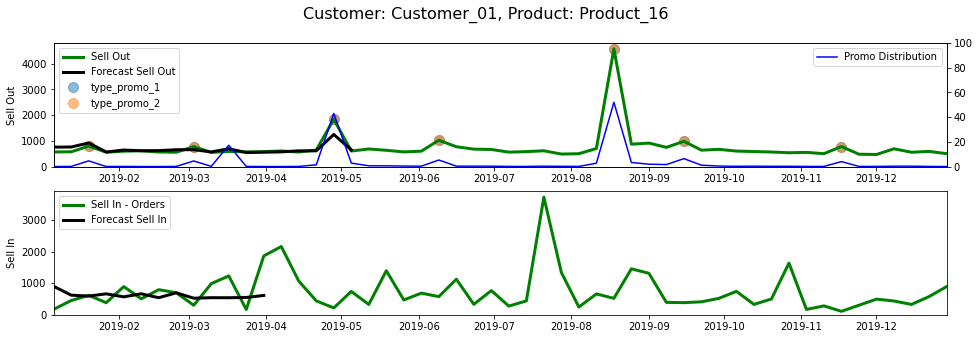

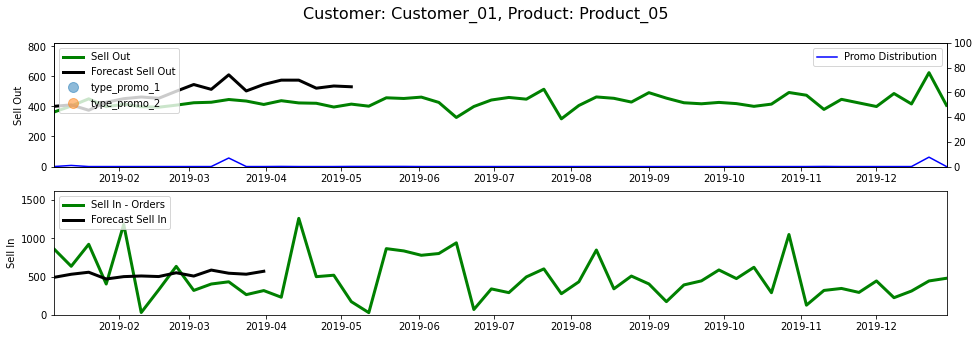

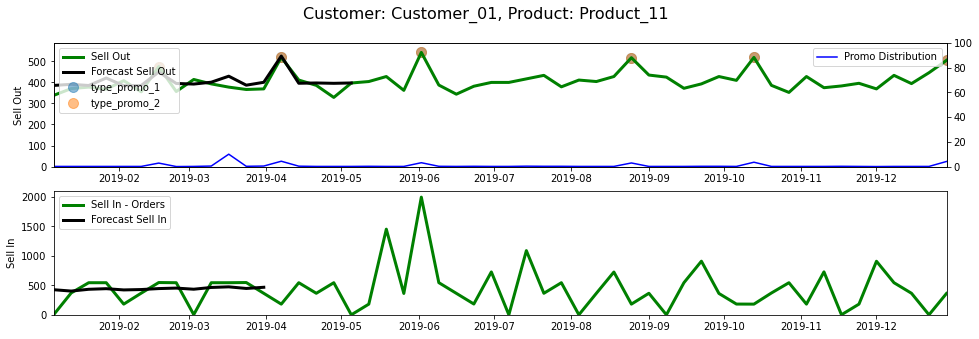

In [19]:
for idx in range(biggest_products.shape[0])[:20]:
    prod = ((dataset_copied[['customer_name', 'product_group']]==biggest_products.iloc[idx, :2]).all(axis=1))
    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(f'Customer: {biggest_products.iloc[idx, 0]}, Product: {biggest_products.iloc[idx, 1]}', fontsize=16)
    
    ### Add Sell Out if Scenario 1 or 3 ##
    if (scenario==1)|(scenario==3):
        ##### Plot Sell Out ##
        ax1 = fig.add_subplot(211)
        ax1.plot(dataset_copied.loc[prod, 'PERIOD_TAG'],
                 dataset_copied.loc[prod, 'Sellout'],
                 color='green', label='Sell Out', linewidth=3)
        ### Forecast Sell Out
        sellout_forecast = dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']=='2018-12-30')),
                                              'Prediction_Sellout_1W':f'Prediction_Sellout_{sellout_w}W'].copy()
        sellout_forecast = sellout_forecast.T
        sellout_forecast.index = pd.date_range(start='2019-01-06', periods=sellout_w, freq='7D')
        sellout_forecast.columns = ['Forecast_Sellout']
        ax1.plot(sellout_forecast['Forecast_Sellout'],
                 color='black', label='Forecast Sell Out', linewidth=3)

        ax1.set_ylabel('Sell Out')
    
    ### Add promo if Scenario 1 ##
        if scenario==1:
            ax2 = ax1.twinx()
            ax2.plot(dataset_copied.loc[prod, 'PERIOD_TAG'],
                     dataset_copied.loc[prod, 'numeric_distribution_selling_promotion'], 
                     color='blue', label='Promo Distribution')
            ax1.scatter(dataset_copied.loc[(prod)&(dataset_copied['type_promo_1']==1), 'PERIOD_TAG'], 
                        dataset_copied.loc[(prod)&(dataset_copied['type_promo_1']==1), 'Sellout'],
                        label='type_promo_1', alpha=0.5, s=100)
            ax1.scatter(dataset_copied.loc[(prod)&(dataset_copied['type_promo_2']==1), 'PERIOD_TAG'], 
                        dataset_copied.loc[(prod)&(dataset_copied['type_promo_2']==1), 'Sellout'],
                        label='type_promo_2', alpha=0.5, s=100)
            ax2.set_ylim([0, 100])
            ax2.legend(loc='upper right')
    
        ax1.set_xlim([dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']>='2019-01-01')), 'PERIOD_TAG'].min(),
                      dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']<'2020-01-01')), 'PERIOD_TAG'].max()])
        ax1.set_ylim(ymin=0)
        ax1.legend(loc='upper left')
    ##### Plot Sell In ##
    if (scenario==1)|(scenario==3):
        ax1 = fig.add_subplot(212)
    else:
        ax1 = fig.add_subplot(111)
    ax1.plot(dataset_copied.loc[prod, 'PERIOD_TAG'],
             dataset_copied.loc[prod, 'orders_SellIn'],
             color='green', label='Sell In - Orders', linewidth=3)
    ### Forecast Sell In
    sellin_forecast = dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']=='2018-12-30')),
                                      'Prediction_orders_SellIn_1W':].copy()
    sellin_forecast = sellin_forecast.T
    sellin_forecast.index = pd.date_range(start='2019-01-06', periods=sellin_w, freq='7D')
    sellin_forecast.columns = ['Forecast_SellIn']
    ax1.plot(sellin_forecast['Forecast_SellIn'],
             color='black', label='Forecast Sell In', linewidth=3)
    
    ### Add promo if Scenario 2 ##
    if scenario==2:
        ax2 = ax1.twinx()
        ax2.plot(dataset_copied.loc[prod, 'PERIOD_TAG'], dataset_copied.loc[prod, 'Distribution'], 
                 color='blue', label='Promo Distribution')
        ax2.scatter(dataset_copied.loc[(prod)&(dataset_copied['type_promo_1']==1), 'PERIOD_TAG'], 
                    dataset_copied.loc[(prod)&(dataset_copied['type_promo_1']==1), 'OP']*95,
                    label='type_promo_1', alpha=0.5, s=75)
        ax2.scatter(dataset_copied.loc[(prod)&(dataset_copied['type_promo_2']==1), 'PERIOD_TAG'], 
                    dataset_copied.loc[(prod)&(dataset_copied['type_promo_2']==1), 'H']*90,
                    label='type_promo_2', alpha=0.5, s=75)
        ax2.set_ylim([0, 100])
        ax2.legend(loc='upper right')
    
    ax1.set_ylabel('Sell In')
    ax1.set_xlim([dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']>='2019-01-01')), 'PERIOD_TAG'].min(),
                  dataset_copied.loc[((prod)&(dataset_copied['PERIOD_TAG']<'2020-01-01')), 'PERIOD_TAG'].max()])
    ax1.set_ylim(ymin=0)
    ax1.legend(loc='upper left')
    ################################################################################################
    plt.show()